# Projet P7 - Implémentez un modèle de scoring
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - 10/2024*
<hr>

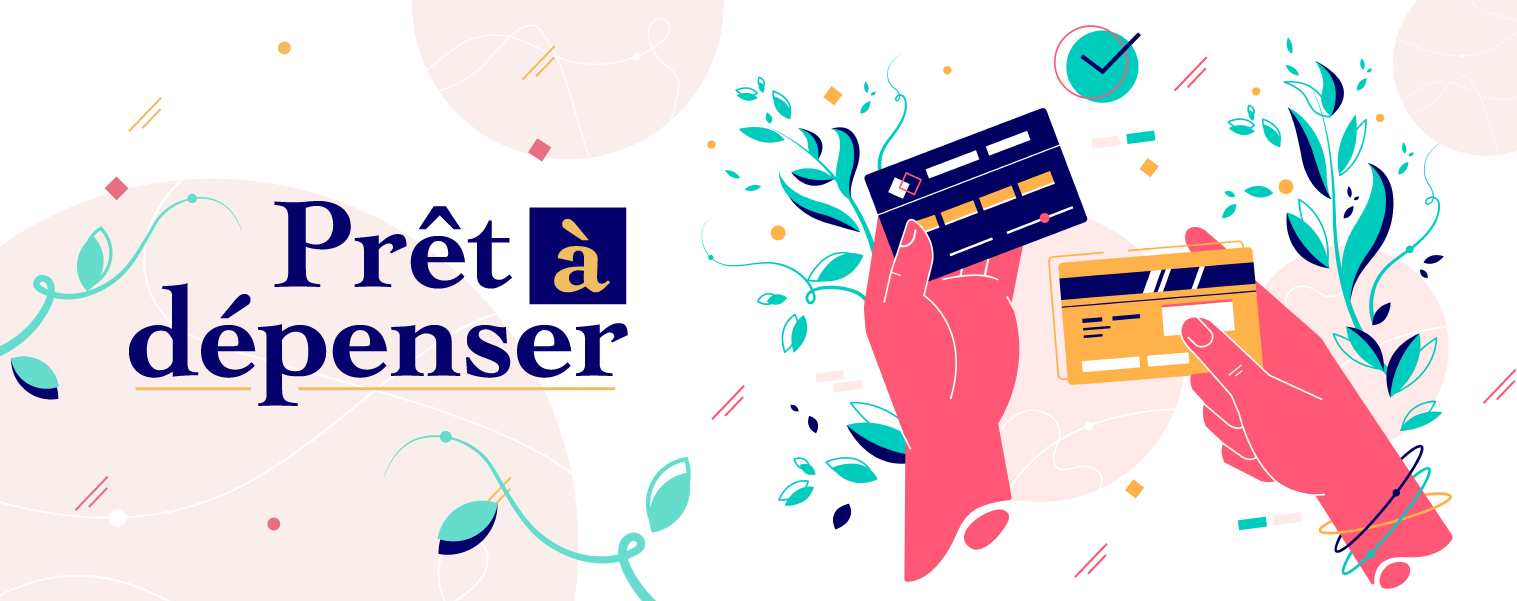

La société financière, **"Prêt à dépenser"**, propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. "Prêt à dépenser" souhaite mettre en œuvre un **outil de “scoring crédit”** pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)

**La mission :**
* Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
* Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.
* Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.
* Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.


[Exemples d'utilisation de MLflow](https://github.com/mlflow/mlflow/tree/master/examples)

# Import libraries

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import json

import shap

In [2]:
# Version python
!python --version

# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.24.4
pandas - 2.2.2
seaborn - 0.13.2
json - 2.0.9
shap - 0.44.1


In [3]:
# Initialisation de shap 
shap.initjs()

In [4]:
# Paramètres par défauts des graphiques
sns.set_style('whitegrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=13)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('font', size=11)          # controls default text sizes
width = 7
height = 5
plt.figure(figsize=(width, height));

<Figure size 700x500 with 0 Axes>

# Functions

In [5]:
import os
import subprocess
import mlflow
import mlflow.sklearn
from mlflow.exceptions import MlflowException
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score, roc_auc_score, precision_score, 
    recall_score, precision_recall_curve, fbeta_score, roc_curve, roc_auc_score, auc
)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


#----------------------------------------------------------------------------------------------------------------------
# SET UP MLFLOW
#----------------------------------------------------------------------------------------------------------------------
def setup_mlflow(experiment_name):
    """!
    @brief Sets up MLflow for tracking experiments and launches the MLflow UI.
    @param experiment_name: str, Name of the experiment to set in MLflow. If None, it tries to fetch it from the `.env` file.
    """
    try:
        # Get the MLflow tracking URI from the .env file, default to SQLite db
        mlflow_uri = os.getenv("MLFLOW_TRACKING_URI", "sqlite:///mlflow.db")

        # Launch MLflow UI
        print(f"Launching MLflow UI at {mlflow_uri}...")
        subprocess.Popen(["mlflow", "ui", "--backend-store-uri", mlflow_uri])
        
        # Set the MLflow tracking URI
        mlflow.set_tracking_uri(mlflow_uri)

        # If no experiment name is provided, use the one from the .env file (if any)
        experiment_name = experiment_name or os.getenv("MLFLOW_EXPERIMENT_NAME")

        if experiment_name:
            # Check if the experiment exists, otherwise create it
            experiment = mlflow.get_experiment_by_name(experiment_name)
            if experiment is None:
                print(f"Experiment '{experiment_name}' not found. Creating a new experiment.")
                mlflow.create_experiment(experiment_name)
            else:
                print(f"Experiment '{experiment_name}' already exists.")
            
            # Set the experiment for the subsequent runs
            mlflow.set_experiment(experiment_name)
            print(f"Using experiment '{experiment_name}'.")
        else:
            print("No experiment name provided or found in the .env file.")
    
    except MlflowException as e:
        print(f"An MLflow error occurred: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

#----------------------------------------------------------------------------------------------------------------------
# EXPERIMENT FUNCTIONS : metrics calculation, searchCV, MLflow tracking and model registry
#----------------------------------------------------------------------------------------------------------------------
def custom_cost_function(y_true, y_pred, fp_weight=1, fn_weight=10):
    """!
    @brief Computes a custom cost function based on false positives (FP) and false negatives (FN).
    @param y_true: array-like, True labels of the dataset.
    @param y_pred: array-like, Predicted labels from the model.
    @param fp_weight: int, Weight assigned to false positives (default: 1).
    @param fn_weight: int, Weight assigned to false negatives (default: 10).
    @return: float, The computed custom cost.
    """
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Compute the custom cost
    cost = ((fp * fp_weight) + (fn * fn_weight)) / (fp + fn + tp + tn)
    return cost

def model_score(y_test, y_pred, beta, fp_weight, fn_weight):
    """!
    @brief Computes multiple evaluation metrics for a classification model, including custom cost and standard scores.
    @param y_test: array-like, Ground truth (true) labels of the dataset.
    @param y_pred: array-like, Predicted labels from the model.
    @param beta: float, Beta value for the F-beta score to weight precision vs recall.
    @param fp_weight: int, Weight assigned to false positives for the custom cost function.
    @param fn_weight: int, Weight assigned to false negatives for the custom cost function.
    @return: dict, A dictionary containing various evaluation metrics:
        - 'accuracy': float, Accuracy score.
        - 'roc_auc': float, Area under the Receiver Operating Characteristic (ROC) curve.
        - 'precision': float, Precision score.
        - 'recall': float, Recall score.
        - 'aucpr': float, Area under the Precision-Recall curve.
        - 'fbeta': float, F-beta score.
        - 'custom_cost': float, The computed custom cost.
    """
    # Calculate the custom cost metric
    custom_cost = custom_cost_function(y_test, y_pred, fp_weight, fn_weight)
    
    # Compute standard evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Compute area under the Precision-Recall curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred)
    aucpr = auc(recall_vals, precision_vals)
    
    # Calculate the F-beta score
    fbeta = fbeta_score(y_test, y_pred, beta=beta)
    
    # Create and populate the dictionary of scores
    score_dict = {
        'accuracy': accuracy,
        'roc_auc': auc_score,
        'precision': precision,
        'recall': recall,
        'aucpr': aucpr,
        'fbeta': fbeta,
        'custom_cost': custom_cost
    }
    
    return score_dict

def log_model_metrics(score_dict, best_params, train_custom_cost, threshold_optimal):
    """!
    @brief Logs model evaluation metrics, parameters, and other relevant details to MLflow.
    @param score_dict: dict, A dictionary containing evaluation metrics for the model (e.g., accuracy, ROC AUC).
    @param best_params: dict, The best hyperparameters identified during model optimization.
    @param train_custom_cost: float, The custom cost metric calculated on the training set.
    @param threshold_optimal: float or None, The optimal threshold for classification, if applicable.
    """
    # Log best hyperparameters
    mlflow.log_params(best_params)

    # Log custom cost on the training set
    mlflow.log_metric("train_custom_cost", train_custom_cost)

    # Log test set metrics
    for metric_name, metric_value in score_dict.items():
        mlflow.log_metric(f"test_{metric_name}", metric_value)

    # Log the optimal threshold if provided
    if threshold_optimal is not None:
        mlflow.log_metric("threshold_optimal", threshold_optimal)


def log_best_model(best_model, X_train, model_name, register):
    """!
    @brief: Log the best model and optionally register it in the MLflow Model Registry.
    @param best_model: The model to log.
    @param X_train: Training data to infer the model signature.
    @param model_name: Name of the model being logged.
    @param register: Boolean indicating whether to register the model in the Model Registry.
    """
    # Infer signature from training data and model predictions
    signature = infer_signature(X_train, best_model.predict(X_train))
    run_name = mlflow.active_run().info.run_name
    artifact_path = f"{run_name}_best_model_{model_name.lower().replace(' ', '_')}"
    
    # Log the model to MLflow
    mlflow.sklearn.log_model(
        sk_model=best_model, 
        artifact_path=artifact_path,
        signature=signature
    )
    
    # Optionally register the model
    if register:
        register_best_model(artifact_path, model_name)

def register_best_model(artifact_path, model_name):
    """!
    @brief: Register the logged model in the MLflow Model Registry.
    @param artifact_path: Path of the artifact to register.
    @param model_name: Name for the registered model.
    """
    try:
        client = MlflowClient()
        run_id = mlflow.active_run().info.run_id
        run = client.get_run(run_id)
        
        # Retrieve the parent run ID if it exists
        parent_run_id = run.data.tags.get('mlflow.parentRunId')
        if parent_run_id:
            parent_run = client.get_run(parent_run_id)
            parent_run_name = parent_run.info.run_name
        else:
            parent_run_name = "no_parent"  
            print("No associated parent run.")
        
        # Construct the model URI and register it
        model_uri = f"runs:/{run_id}/{artifact_path}"
        registered_model_name = f"{parent_run_name}_{model_name.lower().replace(' ', '_')}"
        mlflow.register_model(model_uri=model_uri, name=registered_model_name)
        print(f"Model registered as {registered_model_name}.")
        
    except Exception as e:
        print(f"An error occurred while registering the model: {e}")

def get_scoring_metric(scoring_metric, beta):
    """!
    @brief: Returns a scorer based on the provided scoring metric name.
    @param scoring_metric: str, the name of the scoring metric to use.
                           Options include 'custom_cost' for a custom function, 'fbeta' for F-beta score, or other pre-defined metrics.
    @param beta: int, the beta parameter for the F-beta score.
    @return scorer: A scoring function or metric to be used in model evaluation.
    """
    # If the custom cost function is selected, create a scorer with 'greater_is_better=False'.
    if scoring_metric == 'custom_cost':
        return make_scorer(custom_cost_function, greater_is_better=False)
    
    # If the F-beta score is selected, create a scorer with the specified beta value.
    elif scoring_metric == 'fbeta':
        return make_scorer(fbeta_score, beta=beta)
    
    # Otherwise, return the provided metric name as-is (e.g., for predefined metrics like 'accuracy').
    else:
        return scoring_metric

def create_pipeline(model_name, model, sampling_strategy='auto', sampling_method='none'):
    """!
    @brief: Creates a pipeline with optional scaling and sampling steps.

    @param model_name: str, name of the model being used (for conditional steps).
    @param model: sklearn or imbalanced-learn classifier instance.
    @param sampling_strategy: dict or str, defines the sampling strategy for SMOTE or undersampling.
    @param sampling_method: str, defines the method for handling class imbalance ('smote', 'undersample', 'none').

    @return ImbPipeline object configured with the specified steps.
    """
    steps = []
    
    # Imputation for certain models
    if model_name in ['Logistic Regression', 'Random Forest Classifier'] or sampling_method == 'smote':
        steps.append(('imputer', SimpleImputer(strategy='median')))
    
    # Scaling
    steps.append(('scaling', StandardScaler()))
    
    # Sampling methods
    if sampling_method == 'smote':
        steps.append(('sampling', SMOTE(sampling_strategy=sampling_strategy, random_state=42)))
    elif sampling_method == 'undersample':
        steps.append(('sampling', RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)))
    elif sampling_method not in ['none', 'class_weight']:
        raise ValueError("Invalid sampling_method. Choose from 'none', 'smote', 'class_weight' or 'undersample'.")
    
    # Classification model
    steps.append(('classification', model))
    
    return ImbPipeline(steps)

def configure_search(pipeline, params, search_class, scoring_metric, cv_folds, n_iter):
    """!
    @brief Initializes a search object for hyperparameter tuning using either RandomizedSearchCV or GridSearchCV.
    @param pipeline: sklearn.pipeline.Pipeline, The model pipeline to tune.
    @param params: dict, The hyperparameter grid or distribution for the search.
    @param search_class: class, The search class to use, either RandomizedSearchCV or GridSearchCV.
    @param scoring_metric: str, The scoring metric to optimize for the search.
    @param cv_folds: int, The number of cross-validation folds.
    @param n_iter: int, The number of iterations for RandomizedSearchCV (not used by GridSearchCV).
    @return: A search object (RandomizedSearchCV or GridSearchCV) initialized with the provided parameters.
    """
    if search_class is RandomizedSearchCV:
        return search_class(
            estimator=pipeline,
            param_distributions=params,
            scoring=scoring_metric,
            n_iter=n_iter,
            cv=cv_folds,
            n_jobs=-1
        )
    elif search_class is GridSearchCV:
        return search_class(
            estimator=pipeline,
            param_grid=params,
            scoring=scoring_metric,
            cv=cv_folds,
            n_jobs=-1
        )
    else:
        raise ValueError("search_class must be either RandomizedSearchCV or GridSearchCV.")


def initiate_search(model_name, model, params, search_class, scoring_metric, sampling_method, 
                    sampling_strategy, cv_folds, n_iter, beta):
    """!
    @brief Initializes the search for hyperparameter tuning with a model pipeline and specified sampling method.
    @param model_name: str, Name of the model to be used.
    @param model: estimator, The machine learning model to be tuned.
    @param params: dict, The hyperparameter grid or distribution to be searched.
    @param search_class: class, The search class to use, either RandomizedSearchCV or GridSearchCV.
    @param scoring_metric: str, The metric to optimize during the search (e.g., 'accuracy', 'custom_cost').
    @param sampling_method: str, The method used for sampling in the pipeline (e.g., 'SMOTE').
    @param sampling_strategy: dict or str, The sampling strategy to use for imbalanced data.
    @param cv_folds: int, The number of cross-validation folds.
    @param n_iter: int, The number of iterations for RandomizedSearchCV (not used by GridSearchCV).
    @param beta: float, The beta parameter for fbeta score if the scoring metric is fbeta.
    @return: A search object (RandomizedSearchCV or GridSearchCV) configured with the provided parameters.
    """
    scoring = get_scoring_metric(scoring_metric, beta)  # Get the appropriate scoring metric
    pipeline = create_pipeline(model_name, model, sampling_strategy, sampling_method)  # Create the pipeline
    search = configure_search(pipeline, params, search_class, scoring, cv_folds, n_iter)  # Configure the search
    return search


def train_model(optim_threshold, X_train, y_train, X_test, y_test, search, scoring_metric, beta):
    """!
    @brief Trains the model using hyperparameter search and optimizes the threshold for predictions if required.
    @param optim_threshold: bool, Whether to optimize the threshold for predictions based on a scoring metric.
    @param X_train: array-like, Features for the training set.
    @param y_train: array-like, True labels for the training set.
    @param X_test: array-like, Features for the test set.
    @param y_test: array-like, True labels for the test set.
    @param search: object, A hyperparameter search object (RandomizedSearchCV or GridSearchCV).
    @param scoring_metric: str, The metric used to evaluate the model (e.g., 'accuracy', 'custom_cost').
    @param beta: float, The beta parameter for fbeta score if the scoring metric is fbeta.
    @return: best_model, The best trained model after hyperparameter search.
             threshold_optimal, The optimal threshold value (if optim_threshold is True).
             y_pred, The predicted labels for the test set.
             y_train_pred, The predicted labels for the training set.
    """
    # Fit the hyperparameter search on the training data
    search.fit(X_train, y_train)
    best_model = search.best_estimator_  # Get the best model after search
    threshold_optimal = None
    
    if optim_threshold:
        # Find the optimal threshold for predictions based on the provided metric
        threshold_optimal = find_best_threshold(best_model, X_train, y_train, 
                                                metric_to_optimize=scoring_metric,
                                                beta=beta,
                                                min_thres=0.1, max_thres=1,
                                                step=0.01, plot=True)
        print(f"Best custom_cost for threshold = {threshold_optimal:.2f}")
        
        # Make predictions with the optimized threshold
        test_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = (test_proba >= threshold_optimal).astype(int)

        train_proba = best_model.predict_proba(X_train)[:, 1]
        y_train_pred = (train_proba >= threshold_optimal).astype(int)
    else:
        # Make predictions without threshold optimization
        y_pred = best_model.predict(X_test)
        y_train_pred = best_model.predict(X_train)
    
    return best_model, threshold_optimal, y_pred, y_train_pred


def plot_confusion_matrix(y_train, y_train_pred, y_test, y_pred, model_name):
    """!
    @brief Plots confusion matrices for both training and test sets for the given model.
    @param y_train: array-like, True labels for the training set.
    @param y_train_pred: array-like, Predicted labels for the training set.
    @param y_test: array-like, True labels for the test set.
    @param y_pred: array-like, Predicted labels for the test set.
    @param model_name: str, The name of the model being evaluated (e.g., 'Logistic Regression').
    """
    # Confusion matrix for train set
    cm_train = confusion_matrix(y_train, y_train_pred)  
    cm_train_display = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["Good Client", "Bad Client"])
    cm_train_display.plot(cmap='Blues')
    plt.title(f"Train - Confusion Matrix for {model_name}")
    plt.grid(False)
    plt.show()

    # Confusion matrix for test set
    cm_test = confusion_matrix(y_test, y_pred) 
    cm_test_display = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Good Client", "Bad Client"])
    cm_test_display.plot(cmap='Blues')
    plt.title(f"Test - Confusion Matrix for {model_name}")
    plt.grid(False)
    plt.show()

    
def perform_search(model_name, model, params, X_train, y_train, X_test, y_test, 
                   scoring_metric, search_class, sampling_method, sampling_strategy, cv_folds, n_iter, 
                   beta, fp_weight, fn_weight, register, optim_threshold):
    """!
    @brief Performs a search to find the best model, evaluates it, logs metrics, and saves the model.
    @param model_name: str, The name of the model being used (e.g., 'Logistic Regression').
    @param model: estimator object, The model to train and evaluate.
    @param params: dict, Hyperparameters for search (GridSearchCV or RandomizedSearchCV).
    @param X_train: array-like, Features for training.
    @param y_train: array-like, True labels for training.
    @param X_test: array-like, Features for testing.
    @param y_test: array-like, True labels for testing.
    @param scoring_metric: str, Scoring metric for model evaluation.
    @param search_class: class, The search class to use (GridSearchCV or RandomizedSearchCV).
    @param sampling_method: str, The sampling method to apply (e.g., 'SMOTE').
    @param sampling_strategy: str, The strategy for resampling (e.g., 'minority').
    @param cv_folds: int, Number of cross-validation folds.
    @param n_iter: int, Number of iterations for RandomizedSearchCV.
    @param beta: float, Beta parameter for fbeta score.
    @param fp_weight: int, Weight for false positives in the custom cost function.
    @param fn_weight: int, Weight for false negatives in the custom cost function.
    @param register: bool, Whether to register the model in MLflow.
    @param optim_threshold: bool, Whether to optimize the classification threshold.
    """
    # Initiating the search to find the best model
    search = initiate_search(model_name, model, params, search_class, scoring_metric, 
                             sampling_method, sampling_strategy, cv_folds, n_iter, beta)

    # Start a run for each model in MLflow
    with mlflow.start_run(run_name=model_name, nested=True):
        
        # Train the best model and get predictions
        best_model, threshold_optimal, y_pred, y_train_pred = train_model(optim_threshold, 
                                                                          X_train, y_train, 
                                                                          X_test, y_test, 
                                                                          search, 
                                                                          scoring_metric, 
                                                                          beta)
            
        # Calculate the custom cost function on the training set
        train_custom_cost = custom_cost_function(y_train, y_train_pred, fp_weight, fn_weight)
        
        # Calculate various metrics for the model
        score_dict = model_score(y_test, y_pred, beta, fp_weight, fn_weight)
        
        # Plot confusion matrices for both training and test sets
        plot_confusion_matrix(y_train, y_train_pred, y_test, y_pred, model_name)
       
        # Log model metrics in MLflow
        log_model_metrics(score_dict, search.best_params_, train_custom_cost, threshold_optimal)
        
        # Log the best model in MLflow
        log_best_model(best_model, X_train, model_name, register)

        # Print the best score achieved for the model
        print(f"Best {model_name} model saved in MLflow with {scoring_metric}: {search.best_score_:.3f}")
 
        
        
def run_experiment(models, 
                   X_train, y_train, 
                   X_test, y_test, 
                   run_params,
                   register=True, 
                   cv_folds=5, 
                   n_iter=10):
    """!
    @brief Runs an experiment by performing hyperparameter tuning and model evaluation for a list of models.
    @param models: dict, A dictionary of models and their respective hyperparameter grids to be tuned.
    @param X_train: array-like, Features for training.
    @param y_train: array-like, True labels for training.
    @param X_test: array-like, Features for testing.
    @param y_test: array-like, True labels for testing.
    @param run_params: dict, Parameters for the run including scoring metric, search type, etc.
    @param register: bool, Whether to register the best models in MLflow (default: True).
    @param cv_folds: int, Number of cross-validation folds for grid search (default: 5).
    @param n_iter: int, Number of iterations for RandomizedSearchCV (default: 10).
    """
    # Extracting parameters from the run_params dictionary
    run_type = run_params['run_type']
    scoring_metric = run_params['scoring_metric']
    search_type = run_params['search_type']
    sampling_method = run_params['sampling_method']
    sampling_strategy = run_params['sampling_strategy']
    beta = run_params['beta']
    fp_weight = run_params['fp_weight']
    fn_weight = run_params['fn_weight']
    register = run_params['register']
    optim_threshold = run_params['optim_threshold']
    
    # Set search class based on search type (Randomized or Grid search)
    search_class = RandomizedSearchCV if search_type == 'random' else GridSearchCV
    
    # Generate a unique name for the MLflow run
    run_name=f"{run_type}_{scoring_metric}_{beta}_{search_type}_{sampling_method}_{sampling_strategy}"

    # Start the parent MLflow run
    with mlflow.start_run(run_name=run_name) as parent_run:
        print(f"Parent Run: {run_name}")
        
        # Iterate over each model and perform the search
        for model_name, (model, params) in models.items():
            print(f"Running {model_name}...")
            perform_search(model_name, model, params, X_train, y_train, X_test, y_test, 
                           scoring_metric, search_class, sampling_method, sampling_strategy, 
                           cv_folds, n_iter, beta, fp_weight, fn_weight,
                           register, optim_threshold)

    print("All models have been tuned and logged in MLflow.") 


In [6]:
#----------------------------------------------------------------------------------------------------------------------
# GET RUNS INFO FROM EXPERIMENT
#----------------------------------------------------------------------------------------------------------------------
def get_runs(experiment_name, parent_run_name):
    """!
    @brief Retrieves all the runs from an experiment and filters them by parent run name.
    @param experiment_name: str, The name of the MLflow experiment.
    @param parent_run_name: str, The name of the parent run to filter the child runs.
    @return: list, A list of filtered child runs under the specified parent run.
    """
    client = MlflowClient()
    experiment = client.get_experiment_by_name(experiment_name)
    runs = client.search_runs(experiment_ids=[experiment.experiment_id])

    parent_run_id = None
    for run in runs:
        if run.info.run_name == parent_run_name:
            parent_run_id = run.info.run_id
            break 
    
    if parent_run_id is None:
        print(f"No parent run found with the name: {parent_run_name}")
        return []
    
    filtered_runs = [
        run for run in runs 
        if run.data.tags.get('mlflow.parentRunId') == parent_run_id
    ]
    
    return filtered_runs

def get_metrics(runs):
    """!
    @brief Extracts and compiles metrics for each run in the list of runs.
    @param runs: list, A list of MLflow run objects.
    @return: pd.DataFrame, A DataFrame containing metrics for each run.
    """
    results = []
    for run in runs:
        # Get all metric names and values for the current run
        for metric_name, metric_value in run.data.metrics.items():
            run_result = {
                'model': run.info.run_name,  
                'metric': metric_name,       
                'value': metric_value        
            }
            results.append(run_result)
    
    # Convert the list of results into a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def plot_model_comparisons(experiment_name, parent_run_name):
    """!
    @brief Plots a comparison of model performance metrics across different models.
    @param experiment_name: str, The name of the MLflow experiment.
    @param parent_run_name: str, The name of the parent run to filter the child runs.
    """
    runs = get_runs(experiment_name, parent_run_name)
    results_df = get_metrics(runs)

    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x='metric', y='value', hue='model', data=results_df, palette='plasma')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f')

    plt.title(f'{parent_run_name} : Comparison of Models across Metrics')
    plt.xlabel('Metric')
    plt.ylabel('Metric Value')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()


In [7]:
#----------------------------------------------------------------------------------------------------------------------
# FIND BEST THRESHOLD
#----------------------------------------------------------------------------------------------------------------------
def get_class_probabilities(model, X_test):
    """!
    @brief Retrieves predicted probabilities for the positive class from the model.
    @param model: Estimator object, The trained model for prediction.
    @param X_test: array-like, Test data to get the predicted probabilities.
    @return: array, Predicted probabilities for the positive class.
    """
    return model.predict_proba(X_test)[:, 1]

def calculate_metrics(y_true, y_pred, beta):
    """!
    @brief Calculates various classification metrics including custom cost.
    @param y_true: array-like, True labels of the dataset.
    @param y_pred: array-like, Predicted labels from the model.
    @param beta: float, The beta parameter for F-beta score calculation.
    @return: dict, A dictionary containing various metrics (accuracy, precision, recall, etc.).
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    fbeta = fbeta_score(y_true, y_pred, beta=beta)
    custom_cost = custom_cost_function(y_true, y_pred)
    
    metrics = {
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'sensibilite': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'specificite': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'f1-score': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
        'roc_auc': roc_auc,
        'fbeta': fbeta,
        'custom_cost': custom_cost
    }
    return metrics

def evaluate_thresholds(class_prob, y_true, beta, min_thres, max_thres, step):
    """!
    @brief Evaluates metrics for different thresholds and returns a DataFrame and confusion matrices.
    @param class_prob: array, Predicted probabilities for the positive class.
    @param y_true: array-like, True labels of the dataset.
    @param beta: float, The beta parameter for F-beta score calculation.
    @param min_thres: float, Minimum threshold to evaluate.
    @param max_thres: float, Maximum threshold to evaluate.
    @param step: float, The step size for threshold evaluation.
    @return: tuple, A DataFrame containing the metrics and a list of confusion matrices for each threshold.
    """
    thresholds = []
    metrics_list = []
    conf_matrices = []

    for p in np.arange(min_thres, max_thres, step):
        thresholds.append(p)
        y_pred = (class_prob >= p).astype(int)
        metrics = calculate_metrics(y_true, y_pred, beta)
        metrics['threshold'] = p
        metrics_list.append(metrics)
    
        cm = confusion_matrix(y_true, y_pred)
        conf_matrices.append(cm)
        
    threshold_df = pd.DataFrame(metrics_list)
    
    return threshold_df, conf_matrices


def plot_threshold_metrics(threshold_df, threshold_optimal, metric_to_optimize):
    """!
    @brief Plots metrics for different threshold values.
    @param threshold_df: DataFrame, The metrics for each threshold.
    @param threshold_optimal: float, The optimal threshold value to highlight.
    @param metric_to_optimize: str, The metric to optimize ('custom_cost', 'fbeta', etc.).
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    sns.lineplot(data=threshold_df, x='threshold', y='precision', label='Précision', ax=ax1)
    sns.lineplot(data=threshold_df, x='threshold', y='sensibilite', label='Sensibilité', ax=ax1)
    sns.lineplot(data=threshold_df, x='threshold', y='specificite', label='Spécificité', ax=ax1)
    sns.lineplot(data=threshold_df, x='threshold', y='accuracy', label='Accuracy', ax=ax1)
    sns.lineplot(data=threshold_df, x='threshold', y='roc_auc', label='roc_auc', ax=ax1)
    sns.lineplot(data=threshold_df, x='threshold', y='fbeta', label='fbeta', ax=ax1)
    ax1.axvline(x=threshold_optimal, color="gray", linestyle='--')
    ax1.set_title('Mesures de performance en fonction du seuil')

    sns.lineplot(data=threshold_df, x='threshold', y=metric_to_optimize, label=metric_to_optimize, ax=ax2)
    ax2.axvline(x=threshold_optimal, color="gray", linestyle='--')
    ax2.set_title(f'{metric_to_optimize} en fonction du seuil')

    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrices(conf_matrices, thresholds, per_row=2):
    """!
    @brief Plots confusion matrices for each threshold with a specified number of matrices per row.
    @param conf_matrices: list, List of confusion matrices to plot.
    @param thresholds: list, Threshold values corresponding to the confusion matrices.
    @param per_row: int, Number of confusion matrices per row in the plot.
    """
    num_matrices = len(conf_matrices)
    num_rows = (num_matrices + per_row - 1) // per_row 

    fig, axes = plt.subplots(num_rows, per_row, figsize=(per_row * 4, num_rows * 4))

    if num_rows > 1:
        axes = axes.ravel()
    else:
        axes = [axes] 
        
    for i, (cm, threshold) in enumerate(zip(conf_matrices, thresholds)):
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues', 
                    xticklabels=["Good Client", "Bad Client"], yticklabels=["Good Client", "Bad Client"])
        axes[i].set_title(f'Threshold: {threshold:.2f}')
        axes[i].set_xlabel('Actual') 
        axes[i].set_ylabel('Predicted')  

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def find_best_threshold(model, X, y, metric_to_optimize='custom_cost', beta=2, min_thres=0.1, max_thres=1, step=0.01, plot=True):
    """!
    @brief Finds the optimal threshold for a given model based on a metric.
    @param model: Estimator object, The trained model for predicting probabilities.
    @param X: array-like, Features to predict class probabilities.
    @param y: array-like, True labels of the dataset.
    @param metric_to_optimize: str, The metric to optimize ('custom_cost', 'fbeta', etc.).
    @param beta: float, The beta parameter for F-beta score calculation.
    @param min_thres: float, Minimum threshold to evaluate.
    @param max_thres: float, Maximum threshold to evaluate.
    @param step: float, The step size for threshold evaluation.
    @param plot: bool, Whether to plot the results (default: True).
    @return: float, The optimal threshold value.
    """
    class_prob = get_class_probabilities(model, X)
    threshold_df, conf_matrices = evaluate_thresholds(class_prob, y, beta, min_thres, max_thres, step)
    if metric_to_optimize == 'custom_cost':
        idx = threshold_df[metric_to_optimize].idxmin()
    else:
        idx = threshold_df[metric_to_optimize].idxmax()
    
    # Find the optimal threshold for custom_cost and display the corresponding value
    threshold_optimal = threshold_df['threshold'][idx]
    metric_optimal = threshold_df[metric_to_optimize][idx]
    print(f"Optimal threshold : {threshold_optimal:.2f} with {metric_to_optimize} value: {metric_optimal:.2f}")
    
    # Get the range of confusion matrices to plot (2 before, optimal, 2 after)
    start_idx = max(0, idx - 2)
    end_idx = min(len(threshold_df) - 1, idx + 2)
    
    # Pass the selected range of confusion matrices to the plot function
    if plot:
        plot_threshold_metrics(threshold_df, threshold_optimal, metric_to_optimize)
        plot_confusion_matrices(conf_matrices[start_idx:end_idx+1], threshold_df['threshold'][start_idx:end_idx+1])

    return threshold_optimal


In [8]:
#----------------------------------------------------------------------------------------------------------------------
# COMPARE ALL RUNS FOR MODEL_SELECTION - FIND BEST MODEL
#----------------------------------------------------------------------------------------------------------------------
def get_parent_runs_with_keyword(experiment_name, keyword="model_selection"):
    """!
    @brief Retrieve all parent runs from an experiment that contain a specified keyword in their name.
    @param experiment_name: str, Name of the MLflow experiment to search.
    @param keyword: str, The keyword to filter parent runs by their names (default: "model_selection").
    @return: list, A list of parent runs that contain the keyword in their names.
    """
    client = MlflowClient()
    experiment = client.get_experiment_by_name(experiment_name)
    if experiment is None:
        print(f"No experiment found with the name: {experiment_name}")
        return []
    
    runs = client.search_runs(experiment_ids=[experiment.experiment_id])
    
    # Filter parent runs that have the specified keyword in their name
    parent_runs = [
        run for run in runs 
        if not run.data.tags.get('mlflow.parentRunId') and keyword in run.info.run_name
    ]
    return parent_runs

def get_child_runs(parent_run_id, all_runs):
    """!
    @brief Retrieve all child runs for a specific parent run.
    @param parent_run_id: str, The ID of the parent run.
    @param all_runs: list, All runs from the experiment.
    @return: list, A list of child runs for the specified parent run.
    """
    child_runs = [
        run for run in all_runs 
        if run.data.tags.get('mlflow.parentRunId') == parent_run_id
    ]
    return child_runs

def get_specific_metrics(runs, parent_run_name, metric_names=["test_custom_cost", "test_roc_auc", "test_accuracy"]):
    """!
    @brief Get specific metrics for each run (e.g., test_custom_cost, test_roc_auc, test_accuracy).
    @param runs: list, The list of runs to evaluate.
    @param parent_run_name: str, The name of the parent run (used to identify the model).
    @param metric_names: list, List of metric names to retrieve (default: test_custom_cost, test_roc_auc, test_accuracy).
    @return: pd.DataFrame, A DataFrame containing the specified metrics for each run.
    """
    results = []
    for run in runs:
        for metric_name in metric_names:
            metric_value = run.data.metrics.get(metric_name)
            if metric_value is not None:
                run_result = {
                    'parent_run_name': parent_run_name,
                    'model': run.info.run_name,  
                    'metric': metric_name,       
                    'value': metric_value        
                }
                results.append(run_result)
    
    # Convert the list of results into a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def select_best_model_across_criteria(results_df):
    """!
    @brief Selects the best model based on multiple performance criteria.
    @param results_df: pd.DataFrame, A DataFrame with model performance metrics (e.g., custom_cost, roc_auc, accuracy).
    @return: pd.DataFrame, A DataFrame containing the best model based on composite ranking across metrics.
    """
    # Generate unique model identifier by combining parent_run and model name
    results_df['model_parent'] = results_df.apply(
        lambda row: f"{row['parent_run_name']}_{row['model'].lower().replace(' ', '_')}", axis=1
    )

    # Pivot the DataFrame to have model_parent as rows and metrics as columns
    pivot_df = results_df.pivot(index='model_parent', columns='metric', values='value')

    # Rank models for each metric individually (ascending for cost, descending for others)
    pivot_df['rank_custom_cost'] = pivot_df['test_custom_cost'].rank(ascending=True)
    pivot_df['rank_roc_auc'] = pivot_df['test_roc_auc'].rank(ascending=False)
    pivot_df['rank_accuracy'] = pivot_df['test_accuracy'].rank(ascending=False)

    # Sum ranks to get a composite score for each model-parent combination
    pivot_df['composite_score'] = pivot_df[['rank_custom_cost', 'rank_roc_auc', 'rank_accuracy']].sum(axis=1)

    # Select the model with the lowest composite score
    best_model = pivot_df.nsmallest(1, 'composite_score').reset_index()
    best_model = best_model.merge(results_df[['model_parent', 'parent_run_name', 'model']].drop_duplicates(subset='model_parent'), 
                                  how='left', on='model_parent')

    print("Best model based on composite ranking across test_custom_cost, test_roc_auc, and test_accuracy:")
    pd.set_option('display.max_colwidth', None)
    display(best_model[['model_parent', 'test_custom_cost', 'test_roc_auc', 'test_accuracy']])
    pd.reset_option('display.max_colwidth')

    return best_model

def compare_runs_across_specified_parent_runs(experiment_name, keyword="model_selection"):
    """!
    @brief Compares runs across parent runs with a specified keyword and selects the best model.
    @param experiment_name: str, Name of the MLflow experiment to compare runs in.
    @param keyword: str, The keyword to filter parent runs by their names (default: "model_selection").
    @return: pd.DataFrame, The best model based on a composite ranking of performance metrics.
    """
    # Retrieve all runs from the experiment
    client = MlflowClient()
    experiment = client.get_experiment_by_name(experiment_name)
    all_runs = client.search_runs(experiment_ids=[experiment.experiment_id])

    # Get all parent runs containing the keyword in their name
    parent_runs = get_parent_runs_with_keyword(experiment_name, keyword)
    if not parent_runs:
        print(f"No parent runs found with the keyword '{keyword}'.")
        return None

    all_results = []

    # Process each parent run
    for parent_run in parent_runs:
        parent_run_name = parent_run.info.run_name
        parent_run_id = parent_run.info.run_id
        child_runs = get_child_runs(parent_run_id, all_runs)

        if not child_runs:
            print(f"No child runs found for parent run: {parent_run_name}")
            continue

        # Get the specific metrics for the child runs of the current parent run
        results_df = get_specific_metrics(child_runs, parent_run_name)
        results_df['parent_run'] = parent_run_name  # Add parent run name to results
        all_results.append(results_df)

    # Concatenate all results into a single DataFrame for comparison across all parent runs
    combined_results_df = pd.concat(all_results, ignore_index=True)

    # Select the best model based on composite criteria
    best_model = select_best_model_across_criteria(combined_results_df)

    return best_model


In [9]:
#----------------------------------------------------------------------------------------------------------------------
# RETRIEVE HYPERPARAMETERS OF A MODEL
#----------------------------------------------------------------------------------------------------------------------
def get_logged_model_params(experiment_name, parent_run_name, model_name):
    """!
    @brief Retrieve the hyperparameters (params) of the best model for a specified parent run and model name.
    @param experiment_name: str, The name of the MLflow experiment containing the runs.
    @param parent_run_name: str, The name of the parent run to filter the child models.
    @param model_name: str, The name of the model whose hyperparameters are to be retrieved.
    @return: list, A list of dictionaries containing the hyperparameters of the best model(s) logged.
    """
    client = MlflowClient()
    experiment = client.get_experiment_by_name(experiment_name)
    
    # Search for the parent run ID based on the parent_run_name
    parent_run_id = next((
        run.info.run_id for run in client.search_runs(experiment_ids=[experiment.experiment_id]) 
        if run.info.run_name == parent_run_name
    ), None)
    
    if parent_run_id is None:
        print(f"No parent run found with the name: {parent_run_name}")
        return None
    
    # Initialize a list to store model parameters
    model_params = []
    
    # Iterate through all the runs to find child runs matching the model name
    for run in client.search_runs(experiment_ids=[experiment.experiment_id]):
        if run.data.tags.get('mlflow.parentRunId') == parent_run_id and run.info.run_name == model_name:
            # Construct the artifact path and model URI for the specific model
            artifact_path = f"{run.info.run_name}_best_model_{model_name.lower().replace(' ', '_')}"
            model_uri = f"runs:/{run.info.run_id}/{artifact_path}"
            
            # Load the model and retrieve its hyperparameters (parameters)
            model = mlflow.sklearn.load_model(model_uri)
            model_params.append(model.get_params())
    
    return model_params

In [13]:
def load_model(model_name):
    """!
    @brief: Load the latest version of a model from the MLflow model registry.
    @param model_name: str, the name of the model registered in MLflow.
    @return: Loaded model instance.
    """
    client = MlflowClient()
    
    # get latest version of model
    latest_version_info = client.get_latest_versions(model_name)[-1]
    latest_version = latest_version_info.version
    
    # Load model
    model_uri = f"models:/{model_name}/{latest_version}"
    model = mlflow.sklearn.load_model(model_uri)

    return model, latest_version

# Import data and start experiment

In [11]:
import os
os.environ['MLFLOW_TRACKING_URI'] = 'http://localhost:5000'

In [14]:
model_name = 'model_optimisation_custom_cost_2_grid_class_weight_None_lightgbm_classifier'

In [15]:
load_model(model_name)

KeyboardInterrupt: 

## Import data

In [10]:
final_df = pd.read_pickle('df_final.pkl')

In [11]:
train_df = final_df[final_df['TARGET'].notnull()]
test_df = final_df[final_df['TARGET'].isnull()]

In [12]:
# Define features (X) and target (y)
X = train_df.drop(columns=['TARGET'])
y = train_df['TARGET']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Start experiment

[Experiment-tracking-and-model-registry-with-mlflow](https://medium.com/@johnthuo/experiment-tracking-and-model-registry-with-mlflow-a74c30217e8c)

In [16]:
# Set MLFlow
experiment_name = 'OC_DS_P7_Scoring'
setup_mlflow(experiment_name)

Launching MLflow UI at http://localhost:5000...
An MLflow error occurred: API request to http://localhost:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=OC_DS_P7_Scoring (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001D82FFAA990>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))


In [15]:
seed = 42

# Model selection

## With unbalanced dataset

Utilisation de LightGBM avec le paramètre boosting_type = 'rf' à la place de Random Forest -> plus rapide

Source : [Kaggle - Example of use of LightGBM Random Forest](https://www.kaggle.com/code/ogrellier/feature-selection-with-null-importances)

In [16]:
models = {
    # Dummy Classifier
    'Dummy Classifier': (DummyClassifier(), {
        'classification__strategy': ['prior', 'most_frequent']
    }),

    # Logistic Regression
    'Logistic Regression': (LogisticRegression(random_state=seed), {
        'classification__C': np.logspace(1, 5, 5)
    }),

    # LightGBM RF Classifier
    'Lgb Random Forest Classifier': (LGBMClassifier(objective='binary', 
                                              boosting_type='rf', 
                                              bagging_freq=1,
                                              subsample=0.6,
                                              colsample_bytree=0.7,
                                              random_state=seed), {
        'classification__n_estimators': [100, 200, 500]
    }),

    # LightGBM Classifier
    'LightGBM Classifier': (LGBMClassifier(objective='binary', random_state=seed), {
        'classification__n_estimators': [100, 200, 500]
    })
}


Running with parameters: {'run_type': 'model_selection', 'search_type': 'grid', 'sampling_method': 'none', 'sampling_strategy': None, 'fp_weight': 1, 'fn_weight': 10, 'register': False, 'optim_threshold': False, 'scoring_metric': 'roc_auc', 'beta': 2}
Parent Run: model_selection_roc_auc_2_grid_none_None
Running Dummy Classifier...


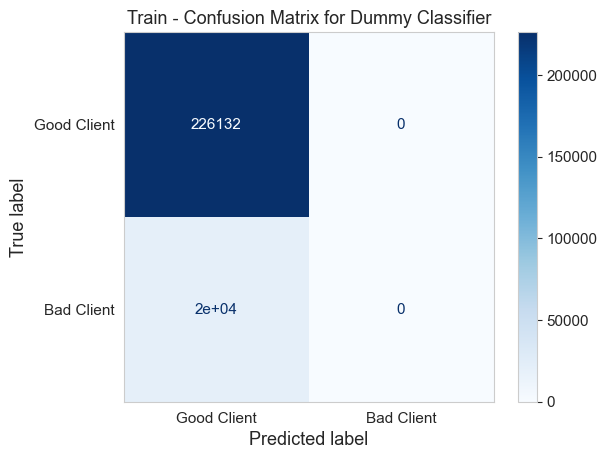

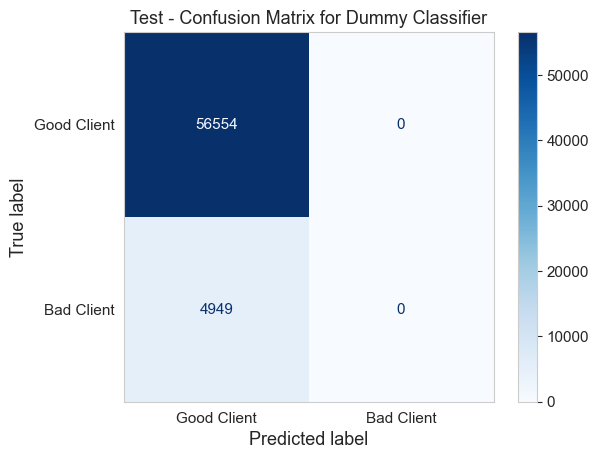

2024/11/08 14:05:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/9/runs/913a644020af457298a453194ea43943.
2024/11/08 14:05:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Dummy Classifier model saved in MLflow with roc_auc: 0.500
Running Logistic Regression...


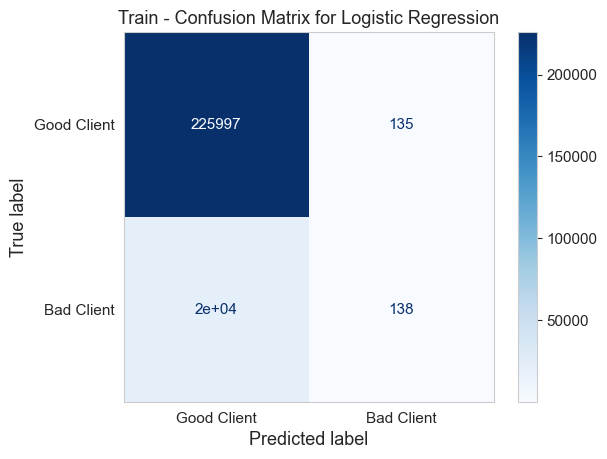

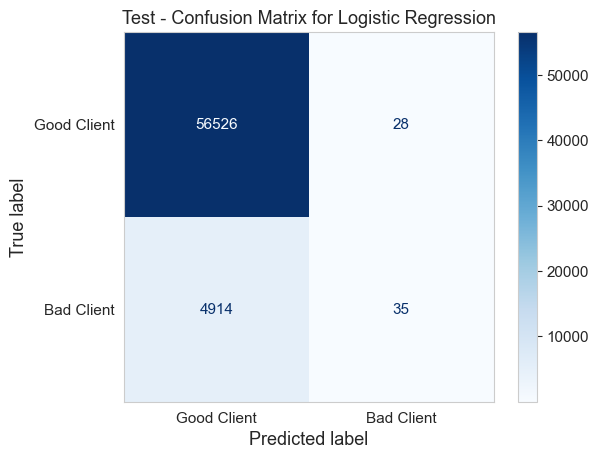

2024/11/08 14:05:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/9/runs/a380b1a229284bdbae55d312c09cb68a.
2024/11/08 14:05:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Logistic Regression model saved in MLflow with roc_auc: 0.735
Running Lgb Random Forest Classifier...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12091
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

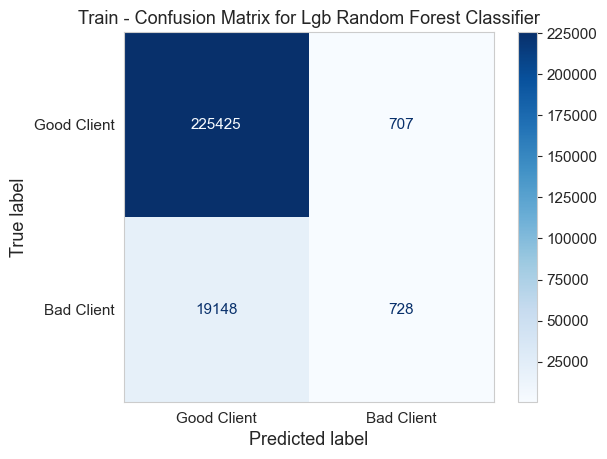

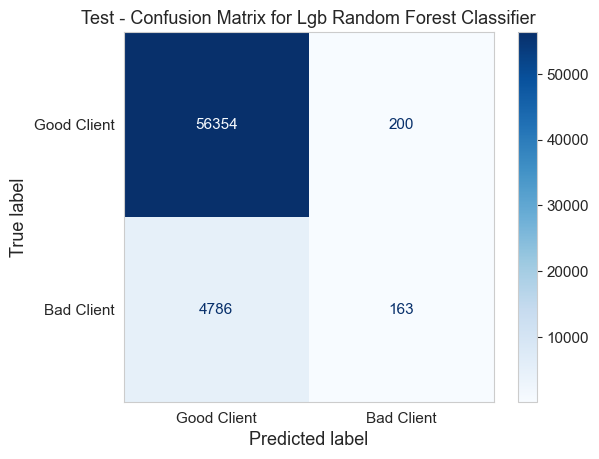

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


2024/11/08 14:06:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lgb Random Forest Classifier at: http://localhost:5000/#/experiments/9/runs/9bf258c0e867451e8e6f94a6018bb41f.
2024/11/08 14:06:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Lgb Random Forest Classifier model saved in MLflow with roc_auc: 0.733
Running LightGBM Classifier...
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12091
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


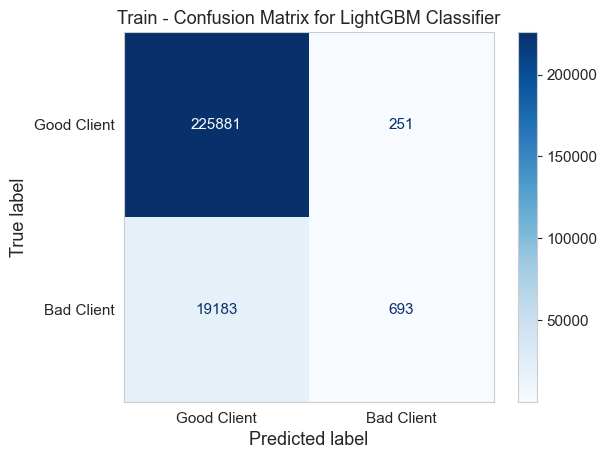

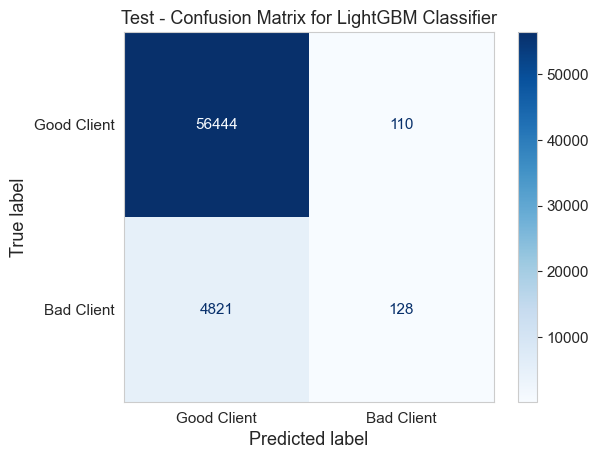

2024/11/08 14:07:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM Classifier at: http://localhost:5000/#/experiments/9/runs/75d29fb499474c948454b3fea4dbd1d4.
2024/11/08 14:07:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.
2024/11/08 14:07:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_selection_roc_auc_2_grid_none_None at: http://localhost:5000/#/experiments/9/runs/ece6dd6045aa484da3968ee9a8cfdea8.
2024/11/08 14:07:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best LightGBM Classifier model saved in MLflow with roc_auc: 0.764
All models have been tuned and logged in MLflow.


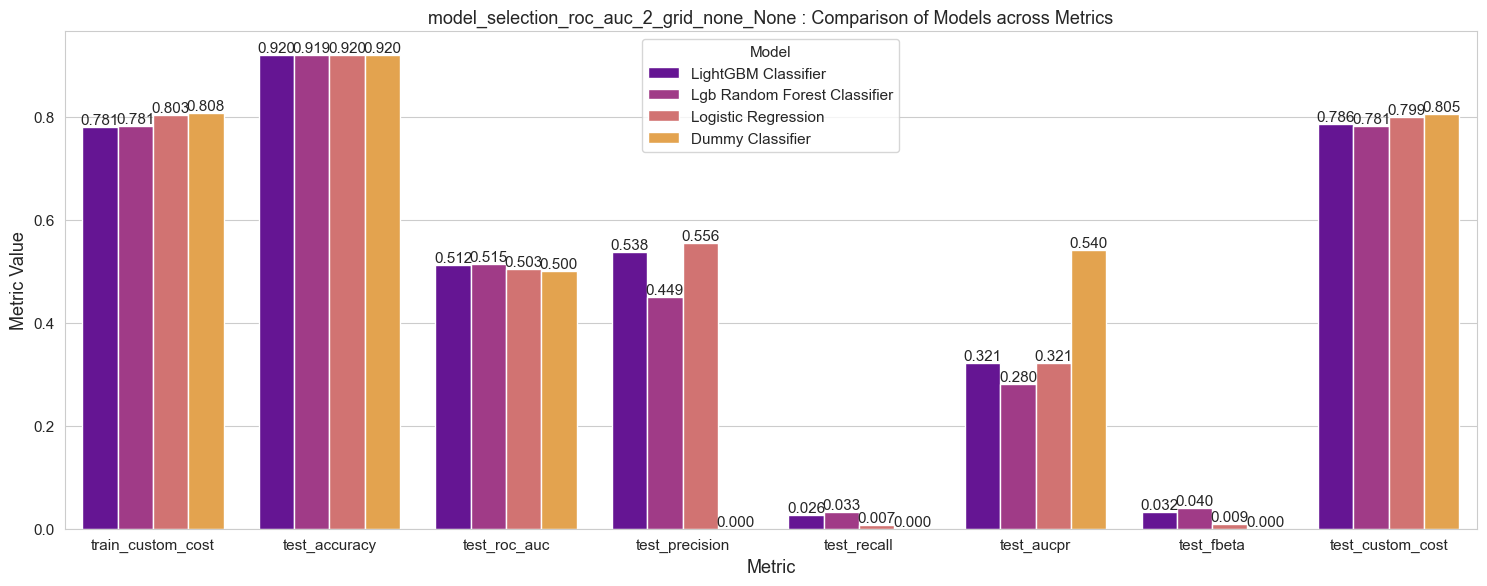

Running with parameters: {'run_type': 'model_selection', 'search_type': 'grid', 'sampling_method': 'none', 'sampling_strategy': None, 'fp_weight': 1, 'fn_weight': 10, 'register': False, 'optim_threshold': False, 'scoring_metric': 'custom_cost', 'beta': 2}
Parent Run: model_selection_custom_cost_2_grid_none_None
Running Dummy Classifier...


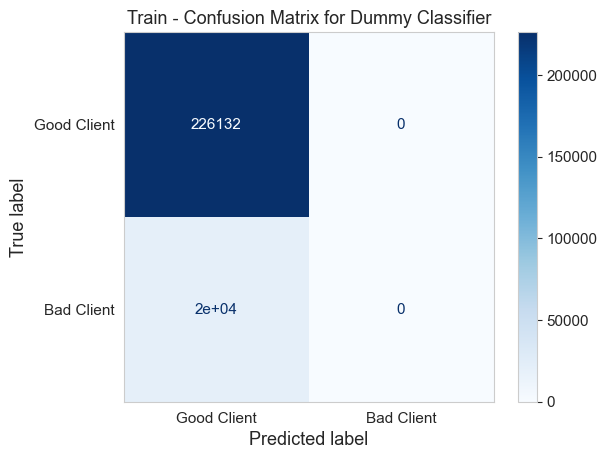

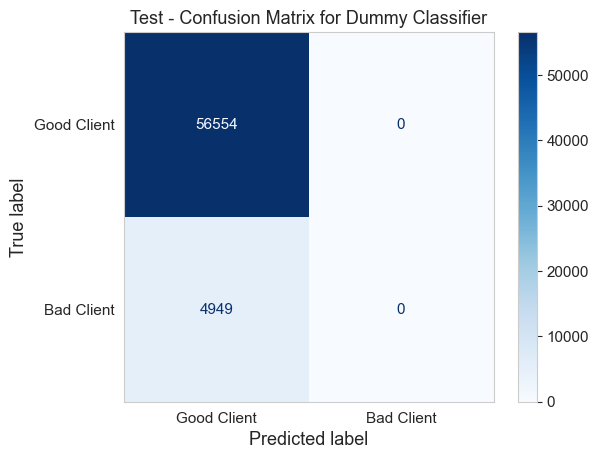

2024/11/08 14:07:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/9/runs/463b61f7e0a949218f0b79c3dde2658b.
2024/11/08 14:07:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Dummy Classifier model saved in MLflow with custom_cost: -0.808
Running Logistic Regression...


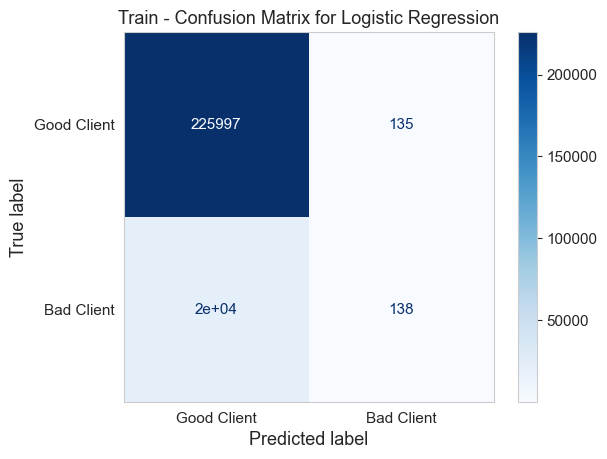

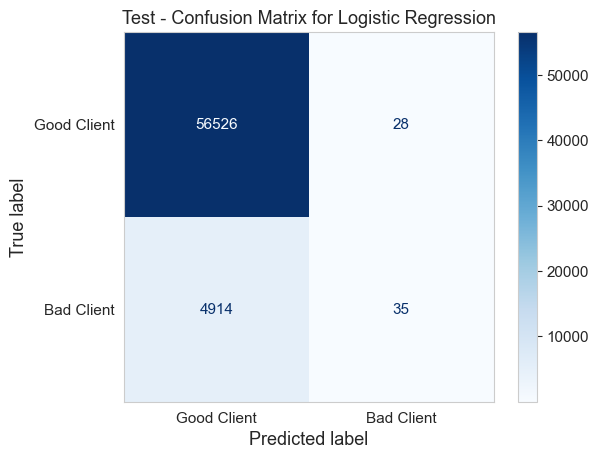

2024/11/08 14:08:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/9/runs/85daf3342a1d454cb853f11ef57a74d8.
2024/11/08 14:08:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Logistic Regression model saved in MLflow with custom_cost: -0.803
Running Lgb Random Forest Classifier...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12091
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will b

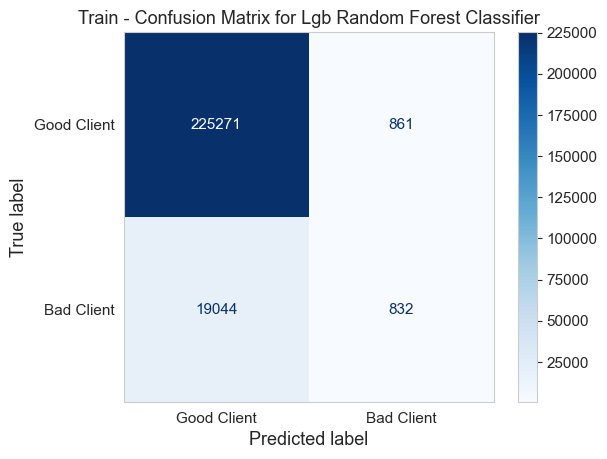

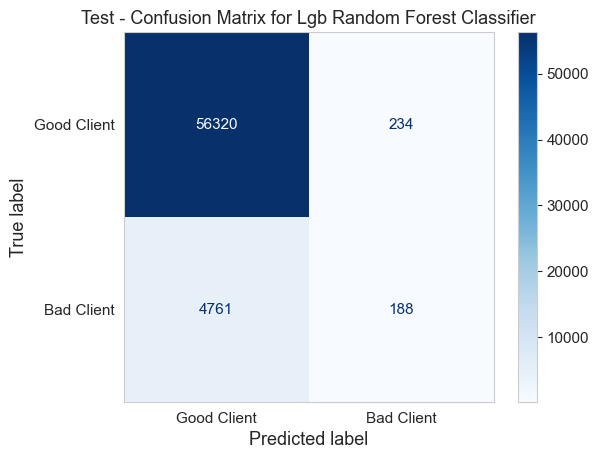

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


2024/11/08 14:09:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lgb Random Forest Classifier at: http://localhost:5000/#/experiments/9/runs/53d781fd853d474fbb0da1a4e7e00582.
2024/11/08 14:09:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Lgb Random Forest Classifier model saved in MLflow with custom_cost: -0.782
Running LightGBM Classifier...
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12091
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


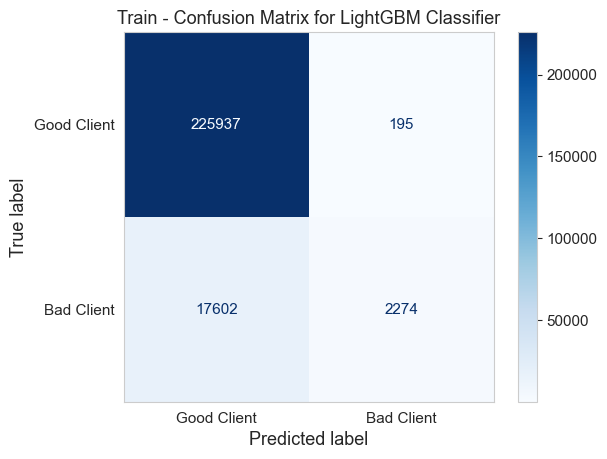

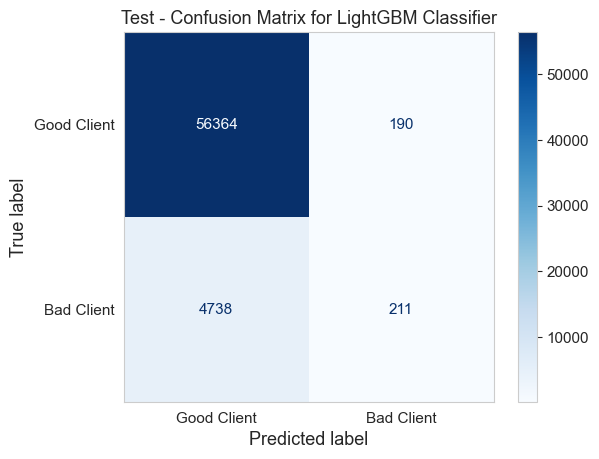

2024/11/08 14:10:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM Classifier at: http://localhost:5000/#/experiments/9/runs/3ca42feee9be4184a51bf5192be6c83a.
2024/11/08 14:10:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.
2024/11/08 14:10:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_selection_custom_cost_2_grid_none_None at: http://localhost:5000/#/experiments/9/runs/8659870da30040efbfa350d143ab361f.
2024/11/08 14:10:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best LightGBM Classifier model saved in MLflow with custom_cost: -0.782
All models have been tuned and logged in MLflow.


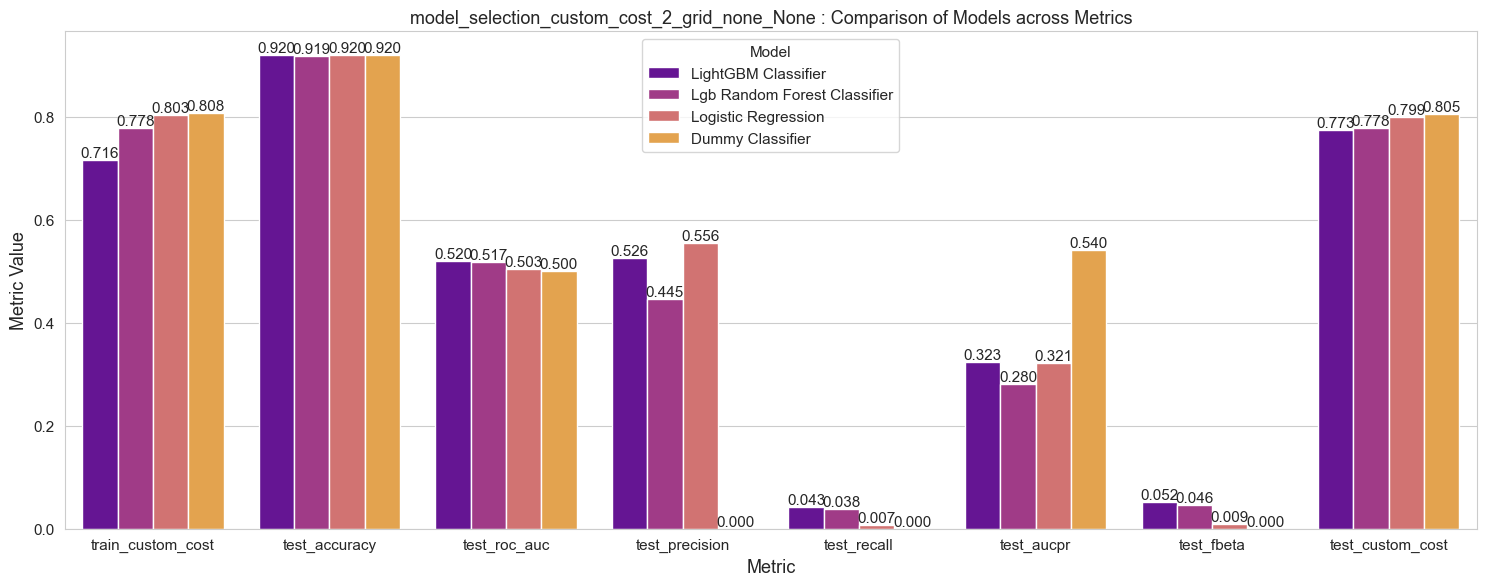

Running with parameters: {'run_type': 'model_selection', 'search_type': 'grid', 'sampling_method': 'none', 'sampling_strategy': None, 'fp_weight': 1, 'fn_weight': 10, 'register': False, 'optim_threshold': False, 'scoring_metric': 'fbeta', 'beta': 2}
Parent Run: model_selection_fbeta_2_grid_none_None
Running Dummy Classifier...


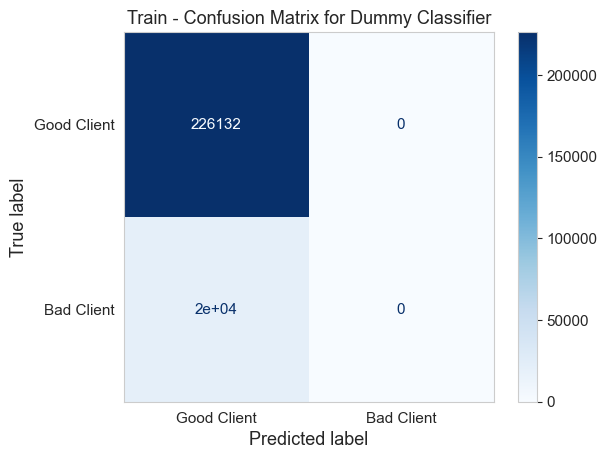

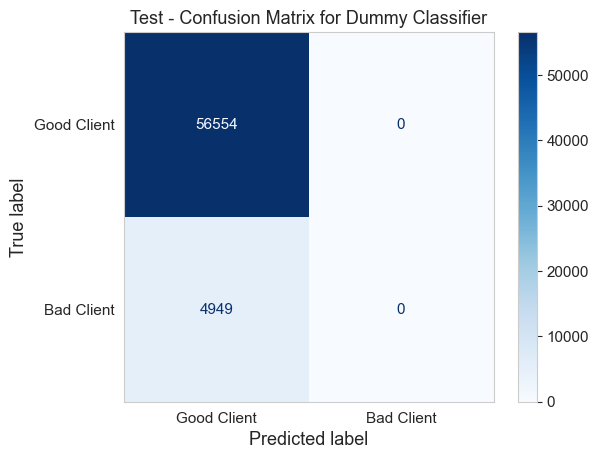

2024/11/08 14:10:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/9/runs/44250fa000f245d8aaa7b28520c2cfe5.
2024/11/08 14:10:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Dummy Classifier model saved in MLflow with fbeta: 0.000
Running Logistic Regression...


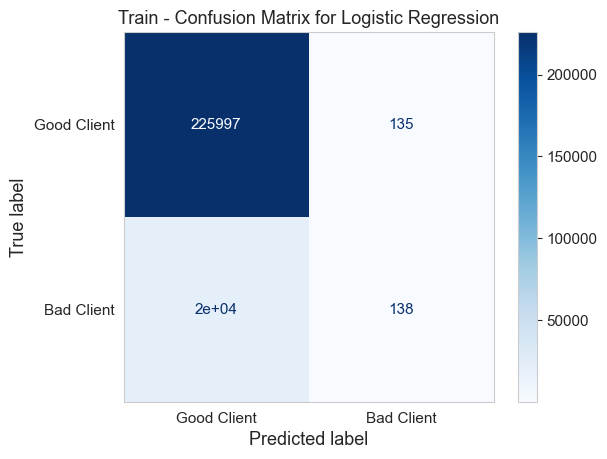

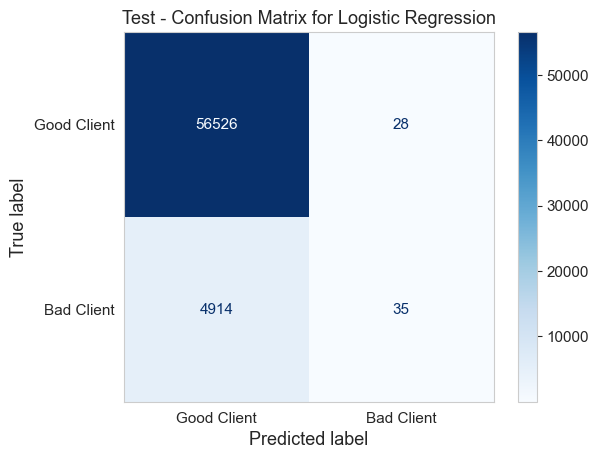

2024/11/08 14:10:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/9/runs/ac3065ffb92747ecb014b5203ab0591f.
2024/11/08 14:10:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Logistic Regression model saved in MLflow with fbeta: 0.008
Running Lgb Random Forest Classifier...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12091
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignor

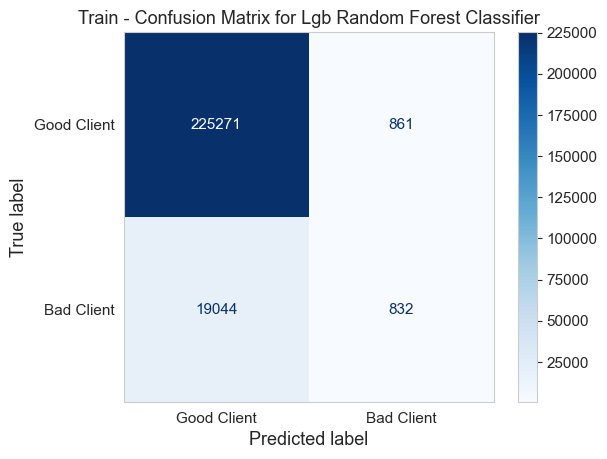

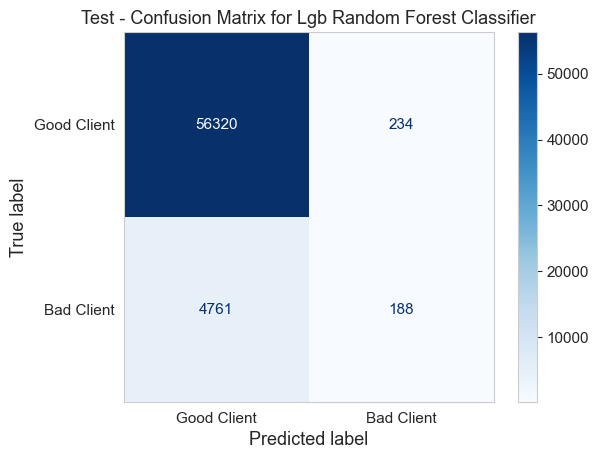

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


2024/11/08 14:11:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lgb Random Forest Classifier at: http://localhost:5000/#/experiments/9/runs/ad9a28d8bb974b759033ad14e862f58d.
2024/11/08 14:11:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Lgb Random Forest Classifier model saved in MLflow with fbeta: 0.046
Running LightGBM Classifier...
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12091
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


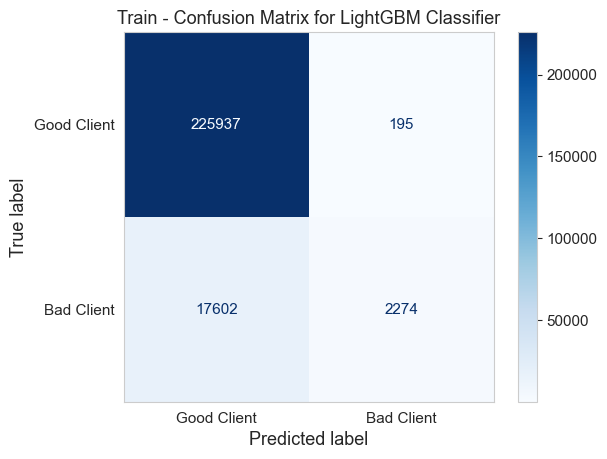

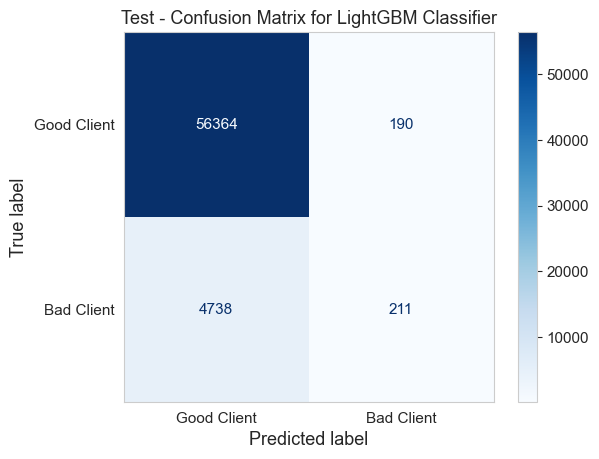

2024/11/08 14:12:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM Classifier at: http://localhost:5000/#/experiments/9/runs/77540344837a4106b4d4418583827331.
2024/11/08 14:12:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.
2024/11/08 14:12:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_selection_fbeta_2_grid_none_None at: http://localhost:5000/#/experiments/9/runs/19bb6d08640d46de95aed2b925f75178.
2024/11/08 14:12:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best LightGBM Classifier model saved in MLflow with fbeta: 0.044
All models have been tuned and logged in MLflow.


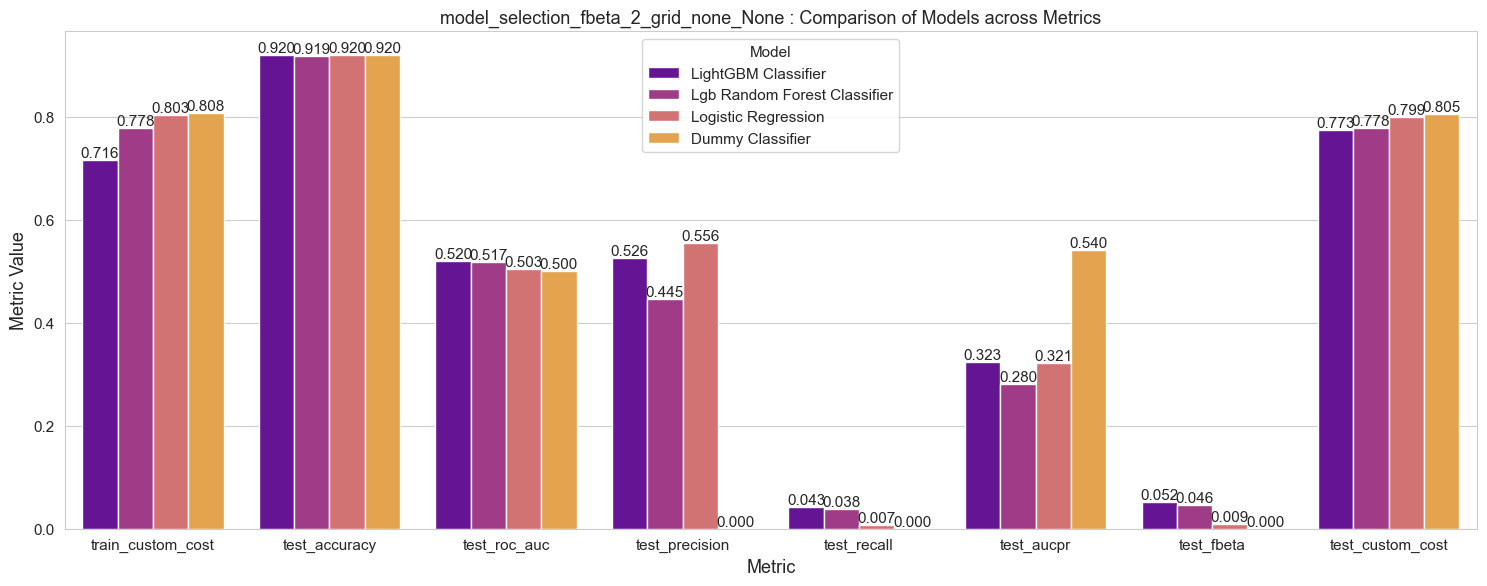

Running with parameters: {'run_type': 'model_selection', 'search_type': 'grid', 'sampling_method': 'none', 'sampling_strategy': None, 'fp_weight': 1, 'fn_weight': 10, 'register': False, 'optim_threshold': False, 'scoring_metric': 'fbeta', 'beta': 3}
Parent Run: model_selection_fbeta_3_grid_none_None
Running Dummy Classifier...


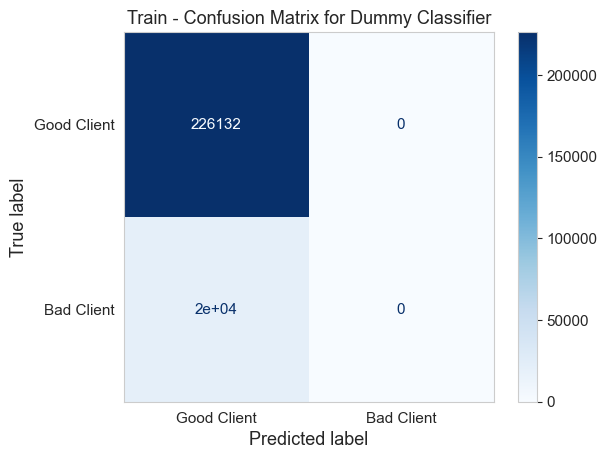

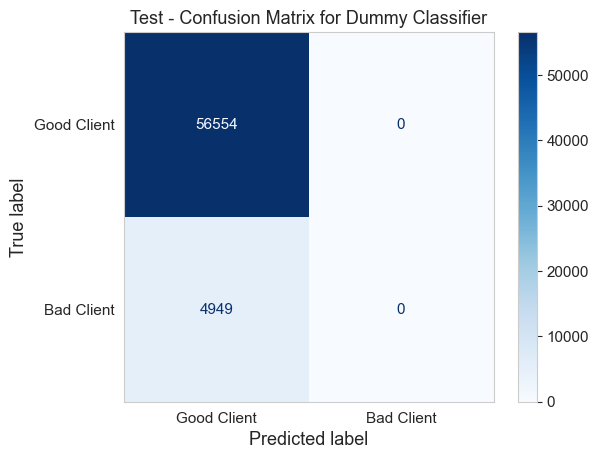

2024/11/08 14:12:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/9/runs/e2ab719412f54a17a40710b833570a96.
2024/11/08 14:12:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Dummy Classifier model saved in MLflow with fbeta: 0.000
Running Logistic Regression...


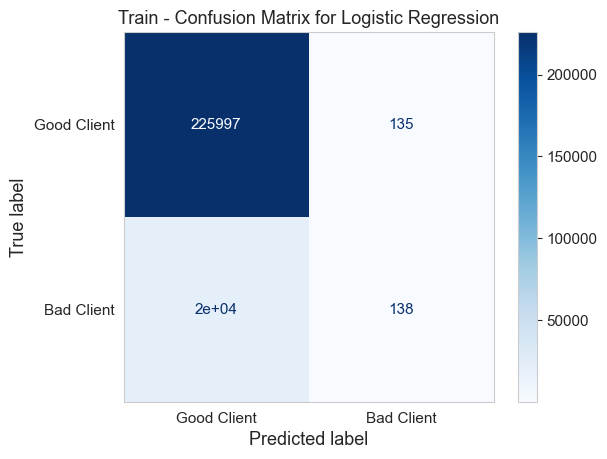

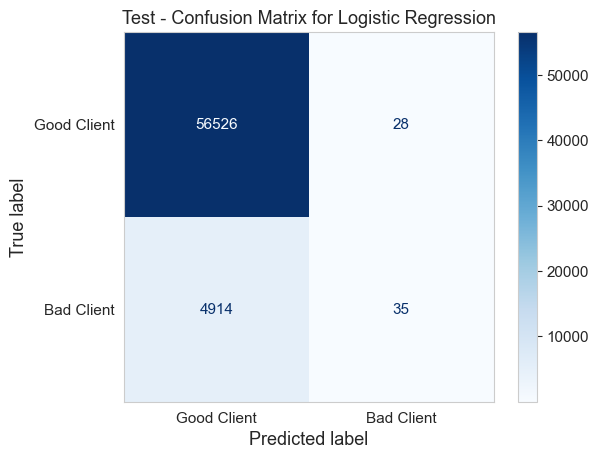

2024/11/08 14:13:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/9/runs/1d0be4a4829d4bc38f64469a8c7b717b.
2024/11/08 14:13:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Logistic Regression model saved in MLflow with fbeta: 0.007
Running Lgb Random Forest Classifier...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12091
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignor

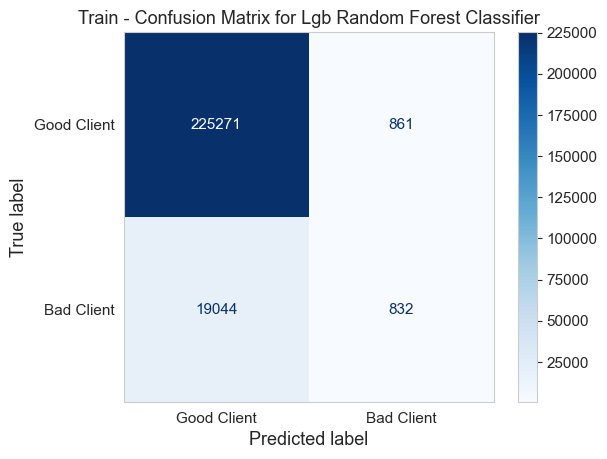

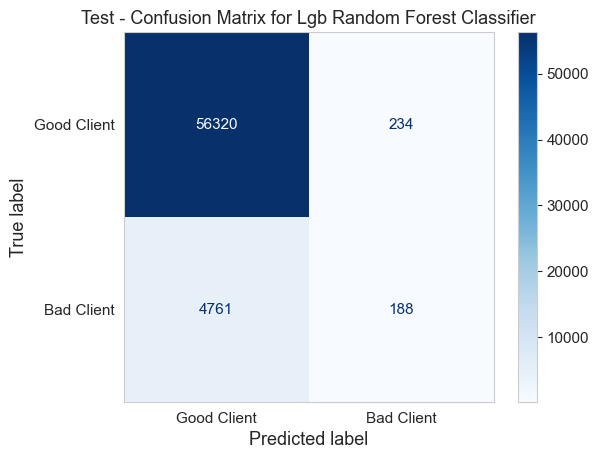

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


2024/11/08 14:14:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lgb Random Forest Classifier at: http://localhost:5000/#/experiments/9/runs/cea2134dd38e46998d0abbde0403bd61.
2024/11/08 14:14:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Lgb Random Forest Classifier model saved in MLflow with fbeta: 0.041
Running LightGBM Classifier...
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12091
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


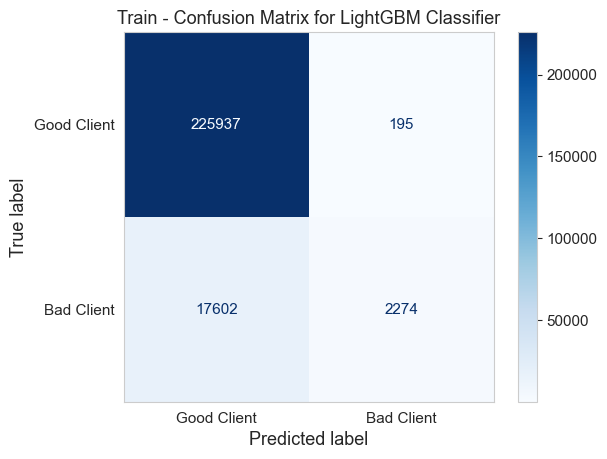

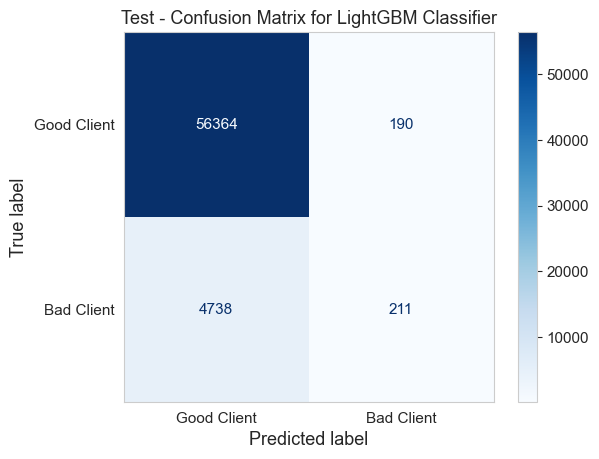

2024/11/08 14:15:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM Classifier at: http://localhost:5000/#/experiments/9/runs/b813262665bd4ef1b89650a0c9622b5c.
2024/11/08 14:15:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.
2024/11/08 14:15:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_selection_fbeta_3_grid_none_None at: http://localhost:5000/#/experiments/9/runs/c164a05d5660469f8fc0f1bf8d4b7617.
2024/11/08 14:15:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best LightGBM Classifier model saved in MLflow with fbeta: 0.040
All models have been tuned and logged in MLflow.


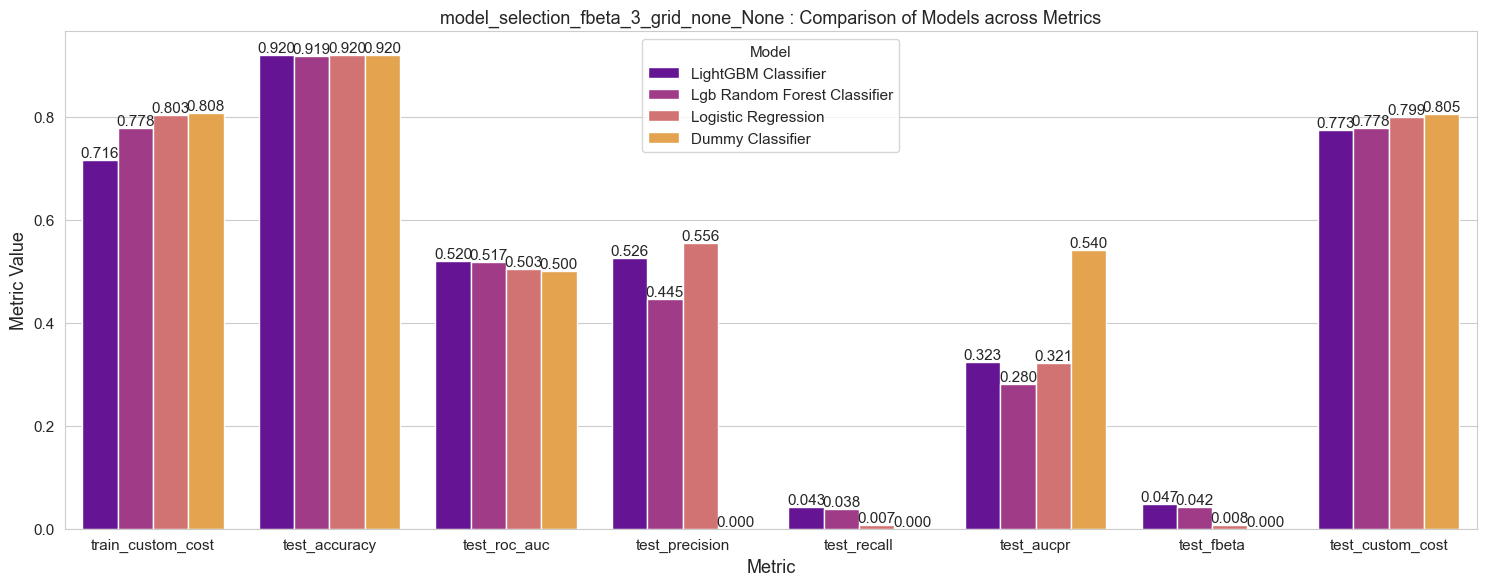

In [17]:
# List of scoring metrics to test
scoring_metrics = [
    {'metric': 'roc_auc', 'beta': 2},  
    {'metric': 'custom_cost', 'beta': 2}, 
    {'metric': 'fbeta', 'beta': 2},  
    {'metric': 'fbeta', 'beta': 3}  
]

# Base parameters
run_params_base_1 = {
    'run_type': 'model_selection',
    'search_type': 'grid',
    'sampling_method': 'none',
    'sampling_strategy': None,
    'fp_weight': 1,
    'fn_weight': 10,
    'register' : False,
    'optim_threshold' : False
}

# Loop over scoring metrics and update run parameters
for scoring in scoring_metrics:
    run_params = run_params_base_1.copy()  
    run_params['scoring_metric'] = scoring['metric']
    run_params['beta'] = scoring['beta']  
    
    # Print or use run_params for model training
    print("Running with parameters:", run_params)
    run_experiment(models, X_train, y_train, X_test, y_test, run_params)
    
    # Plot results
    parent_run_name = f"{run_params['run_type']}_{run_params['scoring_metric']}_{run_params['beta']}_{run_params['search_type']}_{run_params['sampling_method']}_{run_params['sampling_strategy']}"

    plot_model_comparisons(experiment_name, parent_run_name)

## SMOTE - Synthetic Minority Over-sampling Technique - sampling_strategy = 'not majority'

In [18]:
models = {
    # Dummy Classifier
    'Dummy Classifier': (DummyClassifier(), {
        'classification__strategy': ['prior', 'most_frequent']
    }),

    # Logistic Regression
    'Logistic Regression': (LogisticRegression(random_state=seed), {
        'classification__C': np.logspace(1, 5, 5)
    }),

    # LightGBM RF Classifier
    'Lgb Random Forest Classifier': (LGBMClassifier(objective='binary', 
                                              boosting_type='rf', 
                                              bagging_freq=1,
                                              subsample=0.6,
                                              colsample_bytree=0.7,
                                              random_state=seed), {
        'classification__n_estimators': [100, 200, 500]
    }),
    
    # LightGBM Classifier
    'LightGBM Classifier': (LGBMClassifier(objective='binary', random_state=seed, verbosity=-1), {
        'classification__n_estimators': [100, 200, 500]
    })
}


In [19]:
from collections import Counter
# Impute
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# SMOTE with 'not majority' sampling
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

# Class repartition after SMOTE
print("Répartition des classes après SMOTE : ", Counter(y_res))

# Sampling size before and after SMOTE
print(f"Taille de l'échantillon original : {X_train.shape[0]}")
print(f"Taille de l'échantillon après SMOTE : {X_res.shape[0]}")


Répartition des classes après SMOTE :  Counter({0.0: 226132, 1.0: 226132})
Taille de l'échantillon original : 246008
Taille de l'échantillon après SMOTE : 452264


Running with parameters: {'run_type': 'model_selection', 'search_type': 'grid', 'sampling_method': 'smote', 'sampling_strategy': 'not majority', 'fp_weight': 1, 'fn_weight': 10, 'register': False, 'optim_threshold': False, 'scoring_metric': 'roc_auc', 'beta': 2}
Parent Run: model_selection_roc_auc_2_grid_smote_not majority
Running Dummy Classifier...


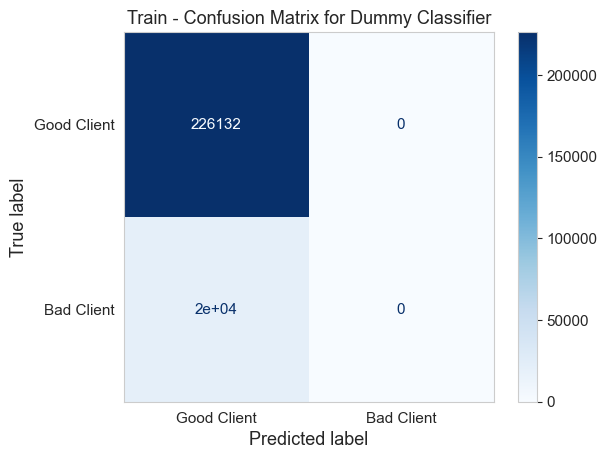

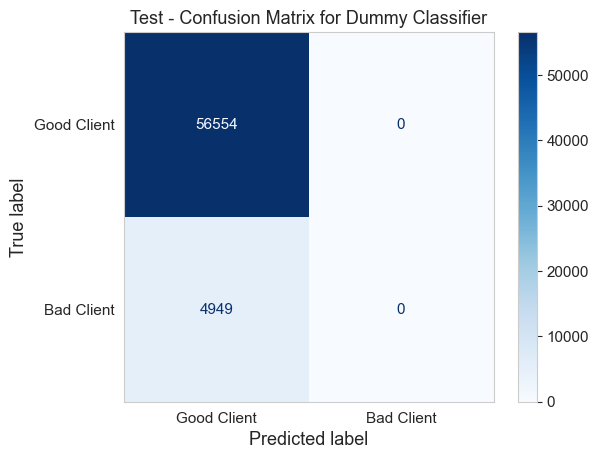

2024/11/08 14:15:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/9/runs/ce2064564c604a3a98055a8899ed5b11.
2024/11/08 14:15:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Dummy Classifier model saved in MLflow with roc_auc: 0.500
Running Logistic Regression...


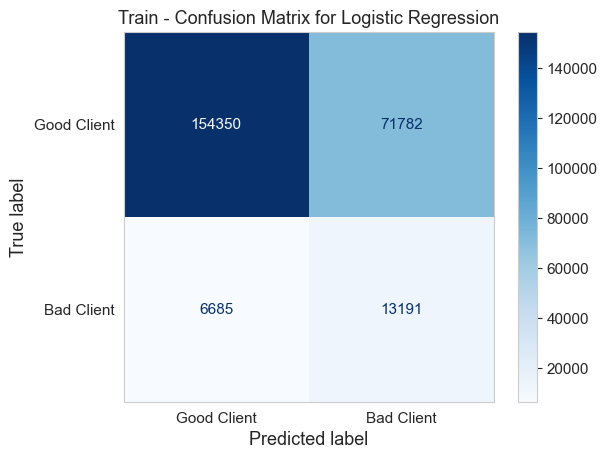

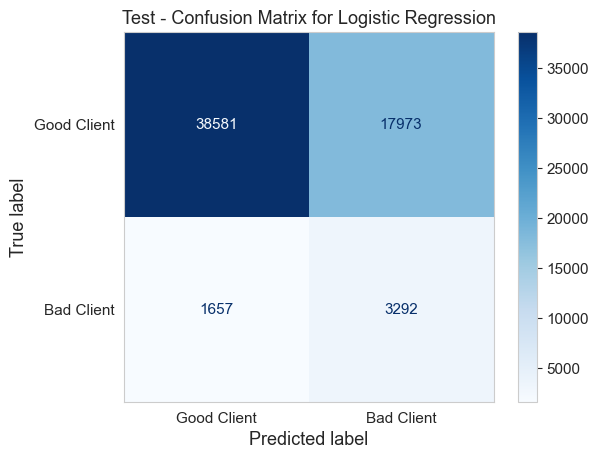

2024/11/08 14:16:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/9/runs/e45ee55fc40a40b9860a910b9f40ca55.
2024/11/08 14:16:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Logistic Regression model saved in MLflow with roc_auc: 0.732
Running Lgb Random Forest Classifier...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 226132, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 452264, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


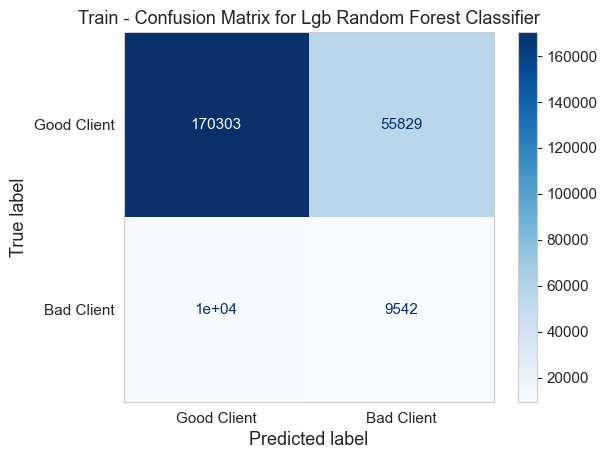

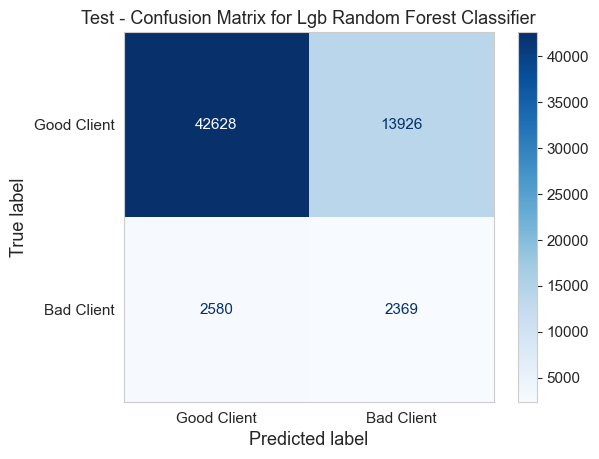

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


2024/11/08 14:18:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lgb Random Forest Classifier at: http://localhost:5000/#/experiments/9/runs/350fe1c67a5a4d3ca2cd4712bbbd30bc.
2024/11/08 14:18:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Lgb Random Forest Classifier model saved in MLflow with roc_auc: 0.678
Running LightGBM Classifier...


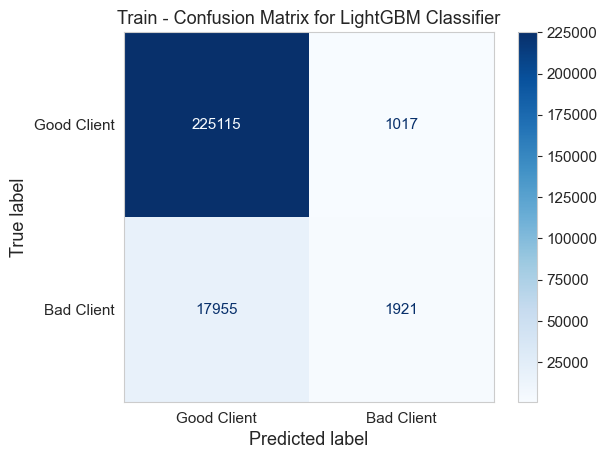

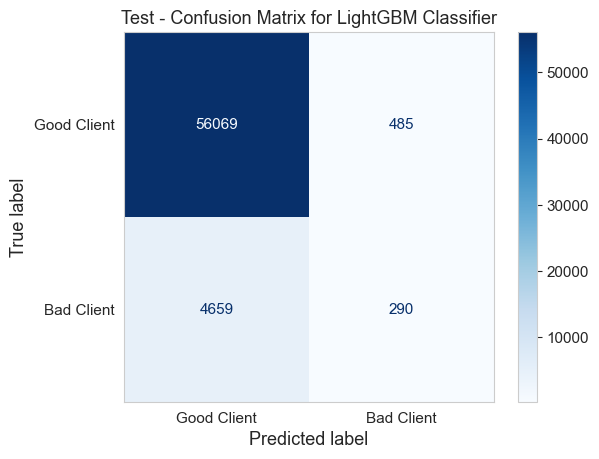

2024/11/08 14:20:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM Classifier at: http://localhost:5000/#/experiments/9/runs/bcde7c2f576d461bb35c68b846a3eb88.
2024/11/08 14:20:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.
2024/11/08 14:20:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_selection_roc_auc_2_grid_smote_not majority at: http://localhost:5000/#/experiments/9/runs/9768bdc9ac38499380f39e3169998298.
2024/11/08 14:20:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best LightGBM Classifier model saved in MLflow with roc_auc: 0.739
All models have been tuned and logged in MLflow.


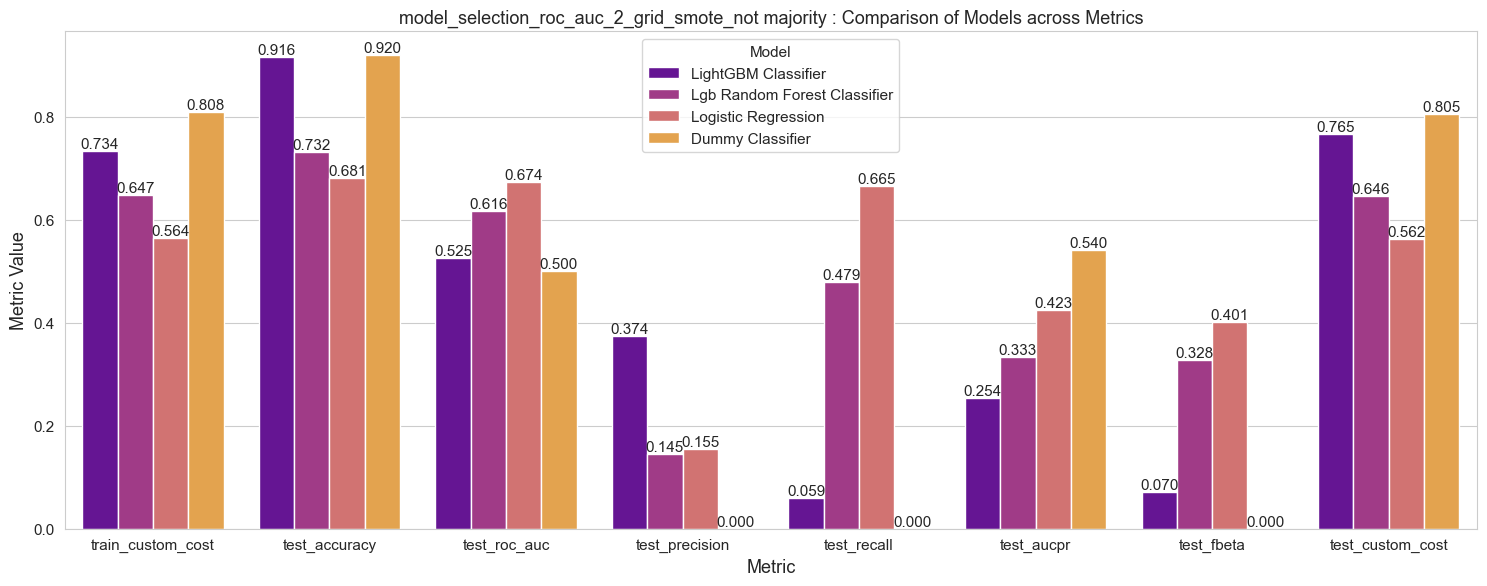

Running with parameters: {'run_type': 'model_selection', 'search_type': 'grid', 'sampling_method': 'smote', 'sampling_strategy': 'not majority', 'fp_weight': 1, 'fn_weight': 10, 'register': False, 'optim_threshold': False, 'scoring_metric': 'custom_cost', 'beta': 2}
Parent Run: model_selection_custom_cost_2_grid_smote_not majority
Running Dummy Classifier...


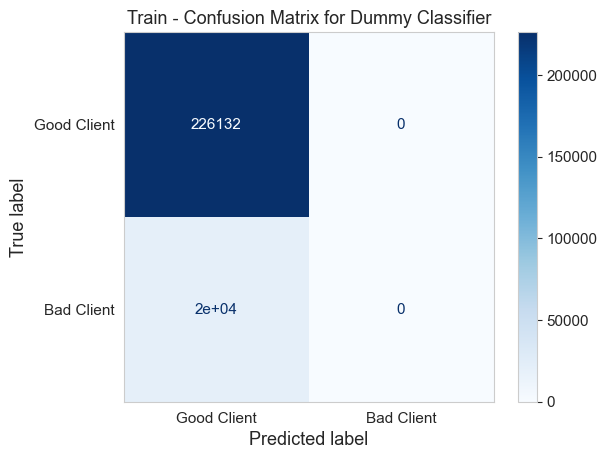

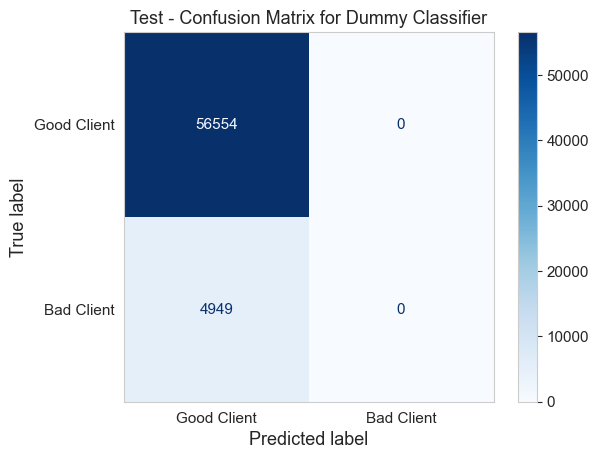

2024/11/08 14:20:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/9/runs/afce2881c2ea4adfafeac2fe08bccfa9.
2024/11/08 14:20:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Dummy Classifier model saved in MLflow with custom_cost: -0.808
Running Logistic Regression...


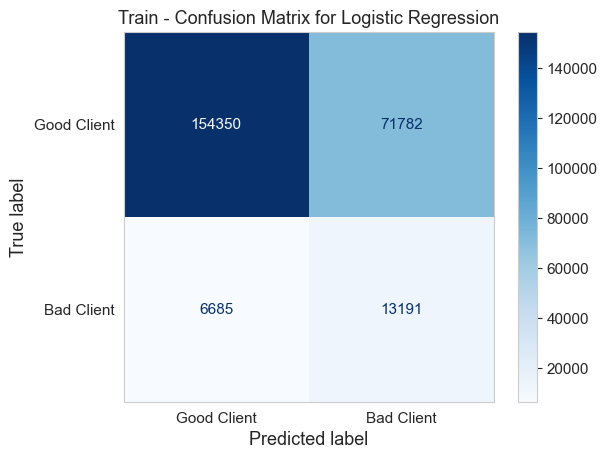

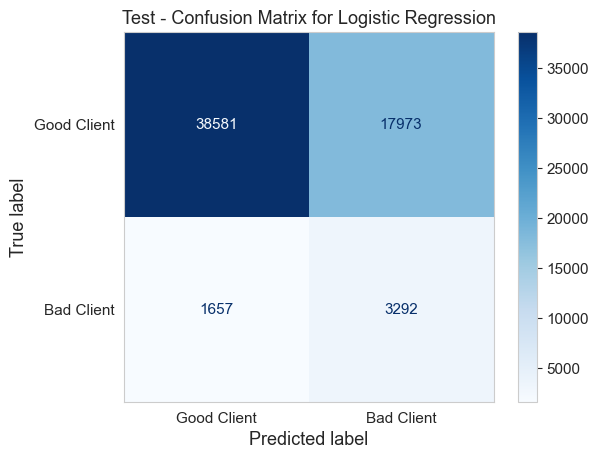

2024/11/08 14:21:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/9/runs/403a2a0407b843f7ae600115201042a9.
2024/11/08 14:21:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Logistic Regression model saved in MLflow with custom_cost: -0.565
Running Lgb Random Forest Classifier...


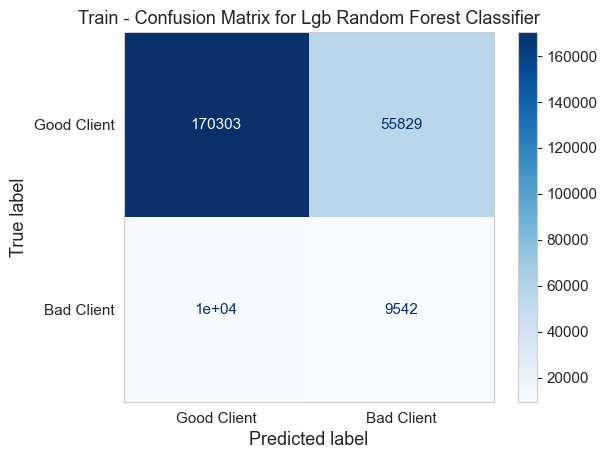

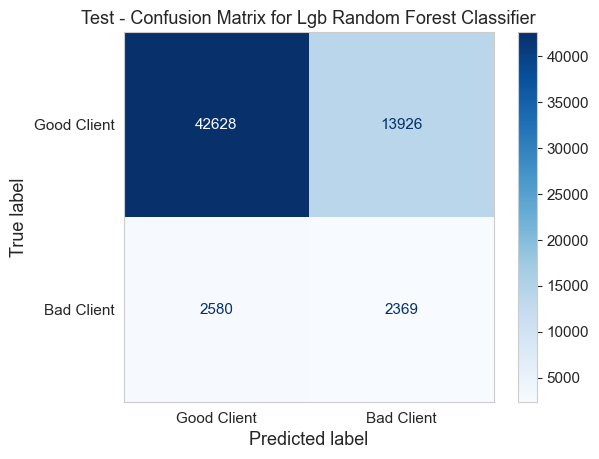

2024/11/08 14:23:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lgb Random Forest Classifier at: http://localhost:5000/#/experiments/9/runs/fa760f9363fc4f319a70bd7e1e606b53.
2024/11/08 14:23:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Lgb Random Forest Classifier model saved in MLflow with custom_cost: -0.651
Running LightGBM Classifier...


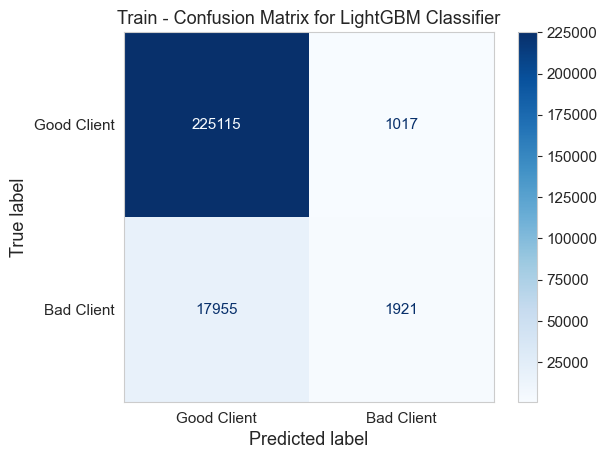

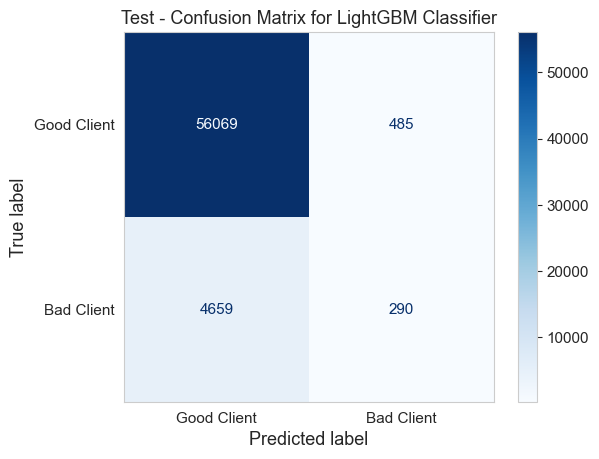

2024/11/08 14:25:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM Classifier at: http://localhost:5000/#/experiments/9/runs/605175b1bc9d4090921e9b1843a10e89.
2024/11/08 14:25:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.
2024/11/08 14:25:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_selection_custom_cost_2_grid_smote_not majority at: http://localhost:5000/#/experiments/9/runs/1891b773f6664a8a9d72cffdb98aafb3.
2024/11/08 14:25:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best LightGBM Classifier model saved in MLflow with custom_cost: -0.770
All models have been tuned and logged in MLflow.


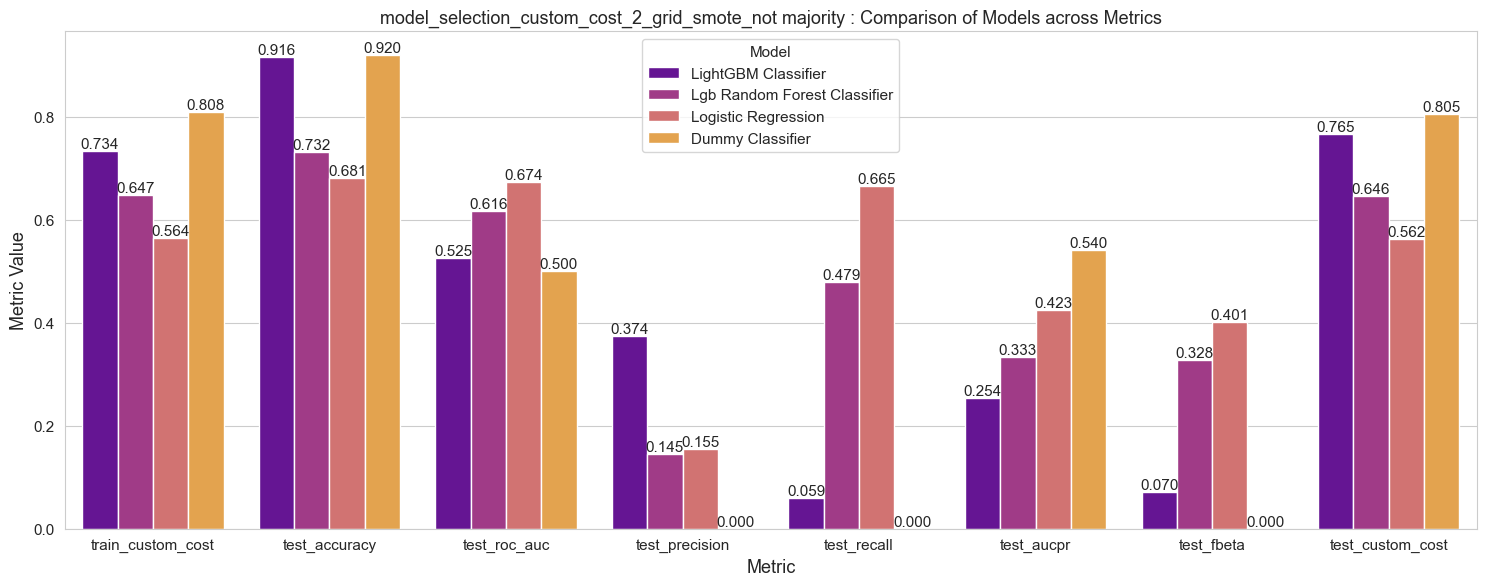

In [20]:
# List of scoring metrics to test
scoring_metrics = [
    {'metric': 'roc_auc', 'beta': 2},  
    {'metric': 'custom_cost', 'beta': 2} 
]

# Base parameters
run_params_base_2 = {
    'run_type': 'model_selection',
    'search_type': 'grid',
    'sampling_method':'smote',
    'sampling_strategy' : 'not majority',
    'fp_weight': 1,
    'fn_weight': 10,
    'register' : False,
    'optim_threshold' : False
}

# Loop over scoring metrics and update run parameters
for scoring in scoring_metrics:
    run_params = run_params_base_2.copy()  
    run_params['scoring_metric'] = scoring['metric']
    run_params['beta'] = scoring['beta']  
    
    # Print or use run_params for model training
    print("Running with parameters:", run_params)
    run_experiment(models, X_train, y_train, X_test, y_test, run_params)
    
    # Plot results
    parent_run_name = f"{run_params['run_type']}_{run_params['scoring_metric']}_{run_params['beta']}_{run_params['search_type']}_{run_params['sampling_method']}_{run_params['sampling_strategy']}"

    plot_model_comparisons(experiment_name, parent_run_name)

## Class_weight = 'balanced'

In [21]:
models = {
    # Dummy Classifier
    'Dummy Classifier': (DummyClassifier(), {
        'classification__strategy': ['prior', 'most_frequent']
    }),

    # Logistic Regression
    'Logistic Regression': (LogisticRegression(class_weight='balanced', random_state=seed), {
        'classification__C': np.logspace(1, 5, 5)
    }),

    # LightGBM RF Classifier
    'Lgb Random Forest Classifier': (LGBMClassifier(class_weight='balanced',
                                                    is_unbalance=True,
                                                    objective='binary', 
                                                    boosting_type='rf', 
                                                    bagging_freq=1,
                                                    subsample=0.6,
                                                    colsample_bytree=0.7,
                                                    random_state=seed), {
        'classification__n_estimators': [100, 200, 500]
    }),

    # LightGBM Classifier
    'LightGBM Classifier': (LGBMClassifier(class_weight='balanced',
                                          is_unbalance=True,
                                           objective='binary', 
                                           random_state=seed), {
        'classification__n_estimators': [100, 200, 500]
    })
}


Running with parameters: {'run_type': 'model_selection', 'search_type': 'grid', 'sampling_method': 'class_weight', 'sampling_strategy': None, 'fp_weight': 1, 'fn_weight': 10, 'register': False, 'optim_threshold': False, 'scoring_metric': 'roc_auc', 'beta': 2}
Parent Run: model_selection_roc_auc_2_grid_class_weight_None
Running Dummy Classifier...


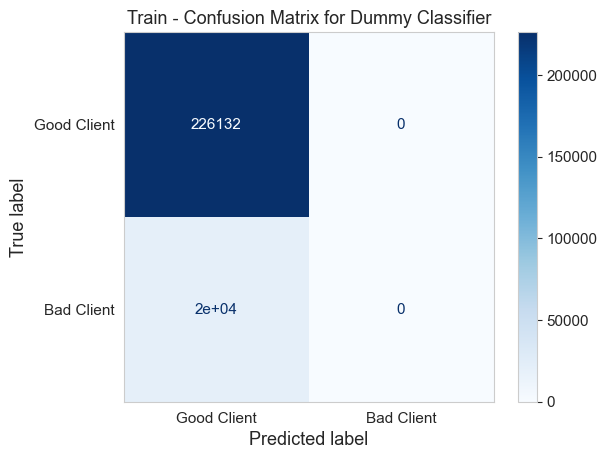

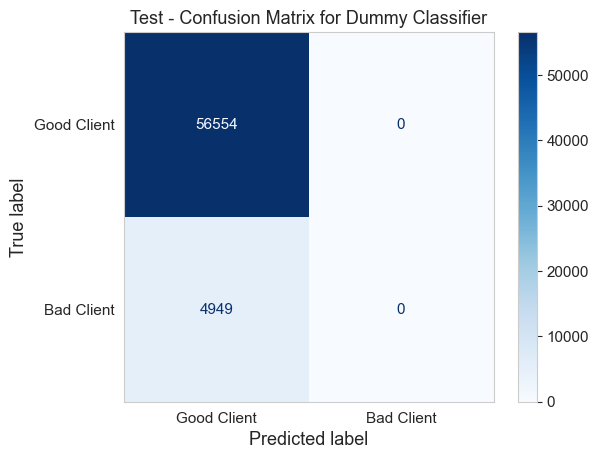

2024/11/08 14:25:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/9/runs/f802bc92f78945feacc4243a9e43dcb4.
2024/11/08 14:25:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Dummy Classifier model saved in MLflow with roc_auc: 0.500
Running Logistic Regression...


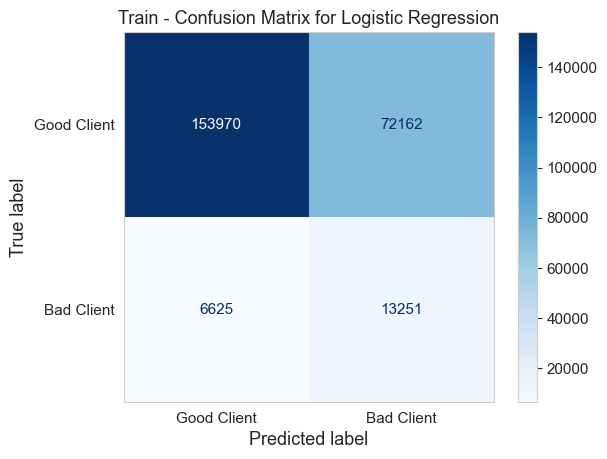

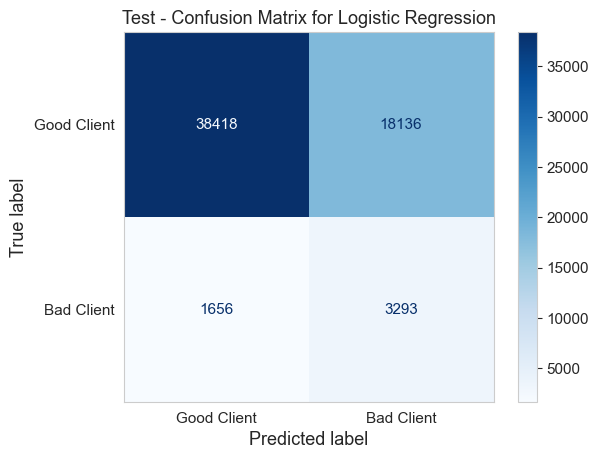

2024/11/08 14:26:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/9/runs/e1c7e971732d45afb61961a97cd16f1c.
2024/11/08 14:26:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Logistic Regression model saved in MLflow with roc_auc: 0.735
Running Lgb Random Forest Classifier...


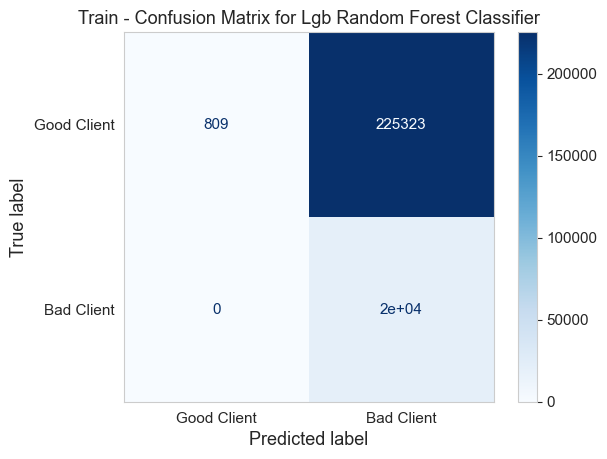

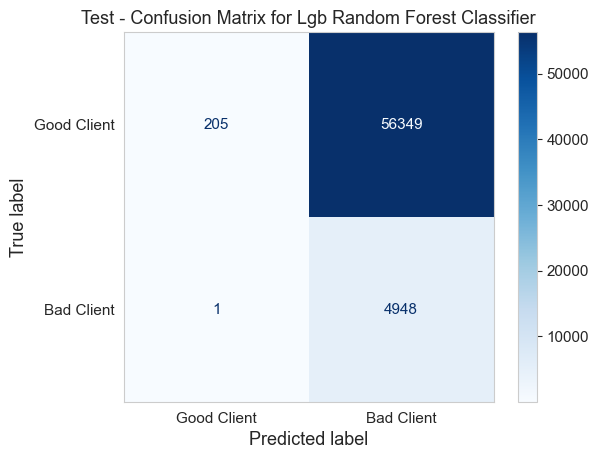

2024/11/08 14:27:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lgb Random Forest Classifier at: http://localhost:5000/#/experiments/9/runs/6a6711a165304570a40b69a4b9327633.
2024/11/08 14:27:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Lgb Random Forest Classifier model saved in MLflow with roc_auc: 0.727
Running LightGBM Classifier...


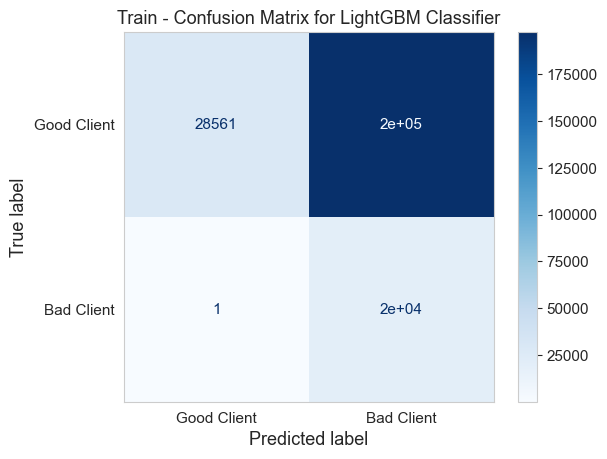

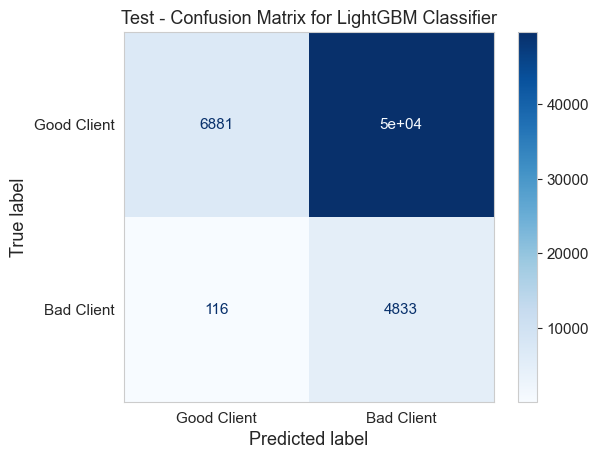

2024/11/08 14:28:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM Classifier at: http://localhost:5000/#/experiments/9/runs/376cb7c85d8e47ce9eb2876504c80edd.
2024/11/08 14:28:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.
2024/11/08 14:28:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_selection_roc_auc_2_grid_class_weight_None at: http://localhost:5000/#/experiments/9/runs/15c5a934c55a476f8cec32842e87bfaf.
2024/11/08 14:28:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best LightGBM Classifier model saved in MLflow with roc_auc: 0.754
All models have been tuned and logged in MLflow.


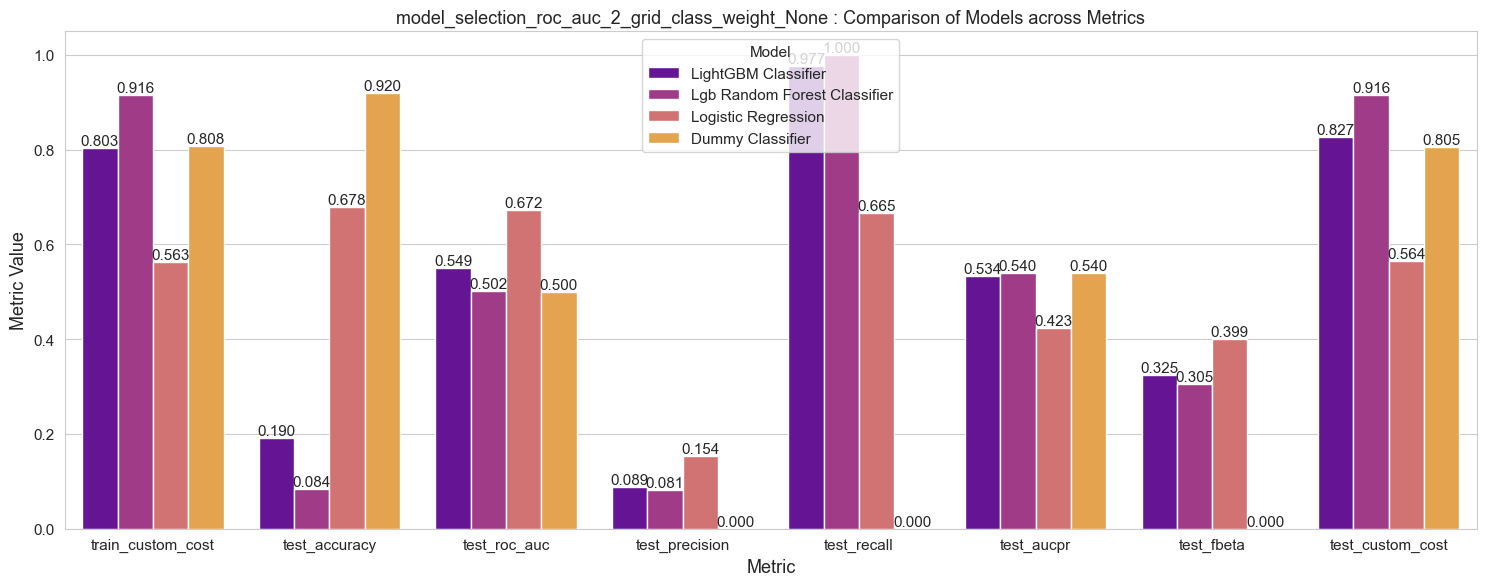

Running with parameters: {'run_type': 'model_selection', 'search_type': 'grid', 'sampling_method': 'class_weight', 'sampling_strategy': None, 'fp_weight': 1, 'fn_weight': 10, 'register': False, 'optim_threshold': False, 'scoring_metric': 'custom_cost', 'beta': 2}
Parent Run: model_selection_custom_cost_2_grid_class_weight_None
Running Dummy Classifier...


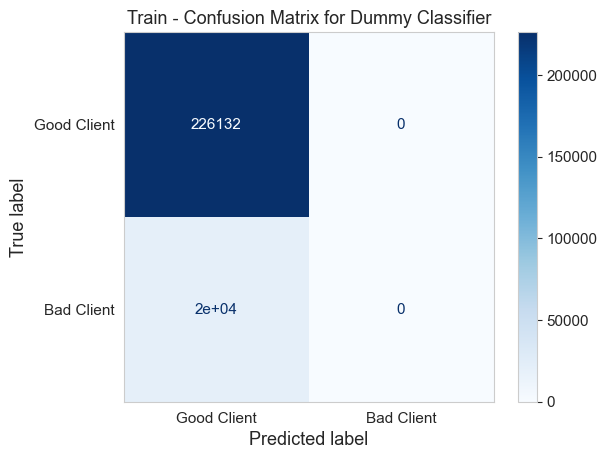

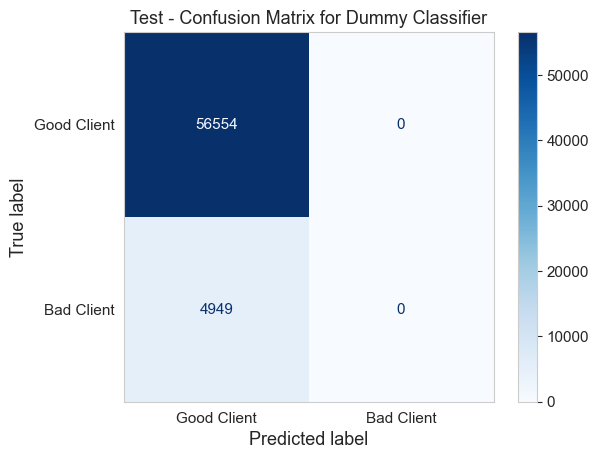

2024/11/08 14:28:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/9/runs/e7c35842b230459390135348ae59b292.
2024/11/08 14:28:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Dummy Classifier model saved in MLflow with custom_cost: -0.808
Running Logistic Regression...


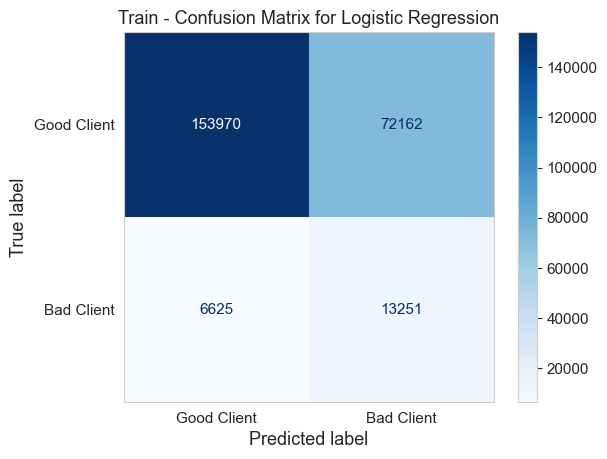

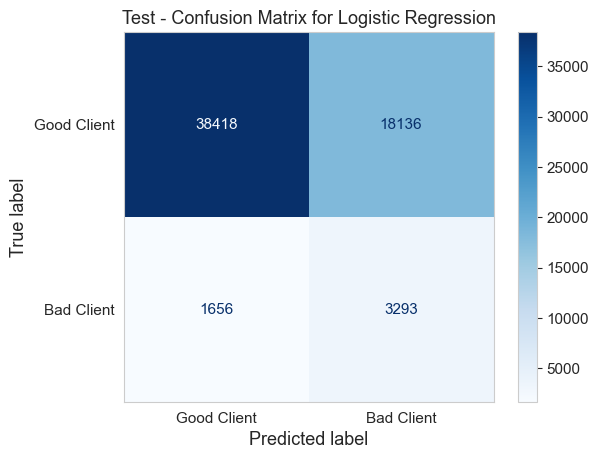

2024/11/08 14:28:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/9/runs/0faafae6409e42958e19198656681855.
2024/11/08 14:28:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Logistic Regression model saved in MLflow with custom_cost: -0.563
Running Lgb Random Forest Classifier...


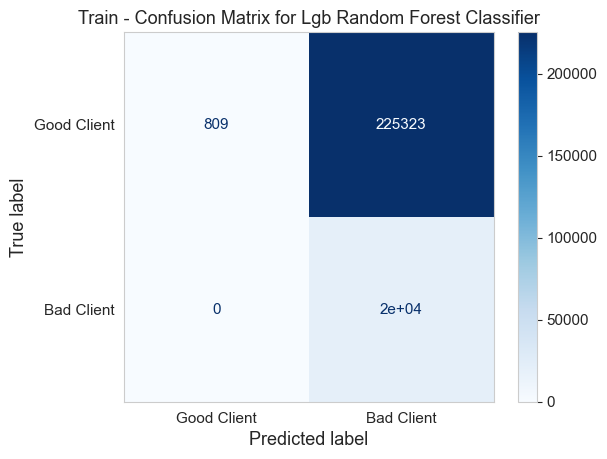

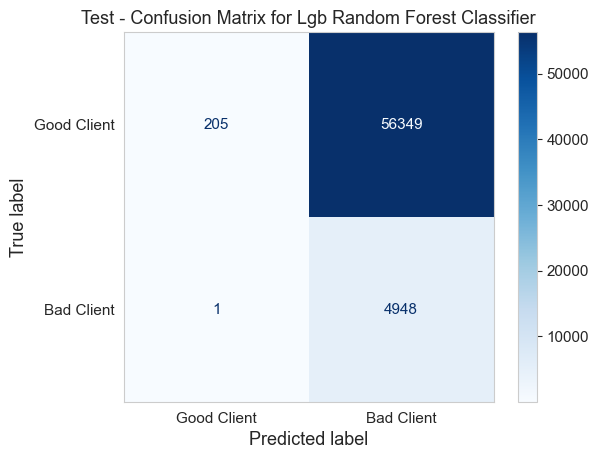

2024/11/08 14:29:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lgb Random Forest Classifier at: http://localhost:5000/#/experiments/9/runs/880b8ebf0a4f44ad8a5f8298bf2d631d.
2024/11/08 14:29:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best Lgb Random Forest Classifier model saved in MLflow with custom_cost: -0.914
Running LightGBM Classifier...


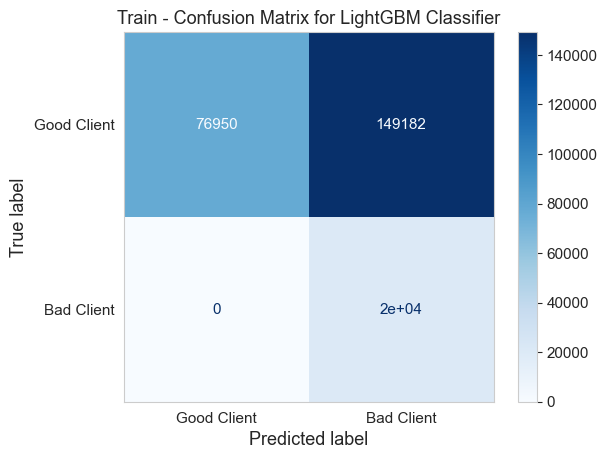

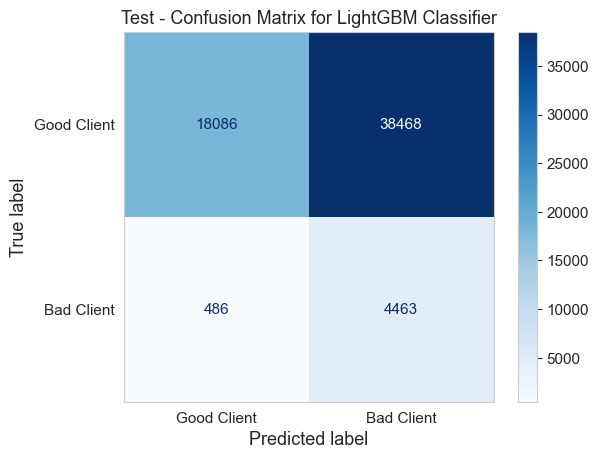

2024/11/08 14:30:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM Classifier at: http://localhost:5000/#/experiments/9/runs/739284f7b00d44e1b7e17a68a03e9352.
2024/11/08 14:30:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.
2024/11/08 14:30:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_selection_custom_cost_2_grid_class_weight_None at: http://localhost:5000/#/experiments/9/runs/4123138e5f4846f1950e0b447276d964.
2024/11/08 14:30:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


Best LightGBM Classifier model saved in MLflow with custom_cost: -0.686
All models have been tuned and logged in MLflow.


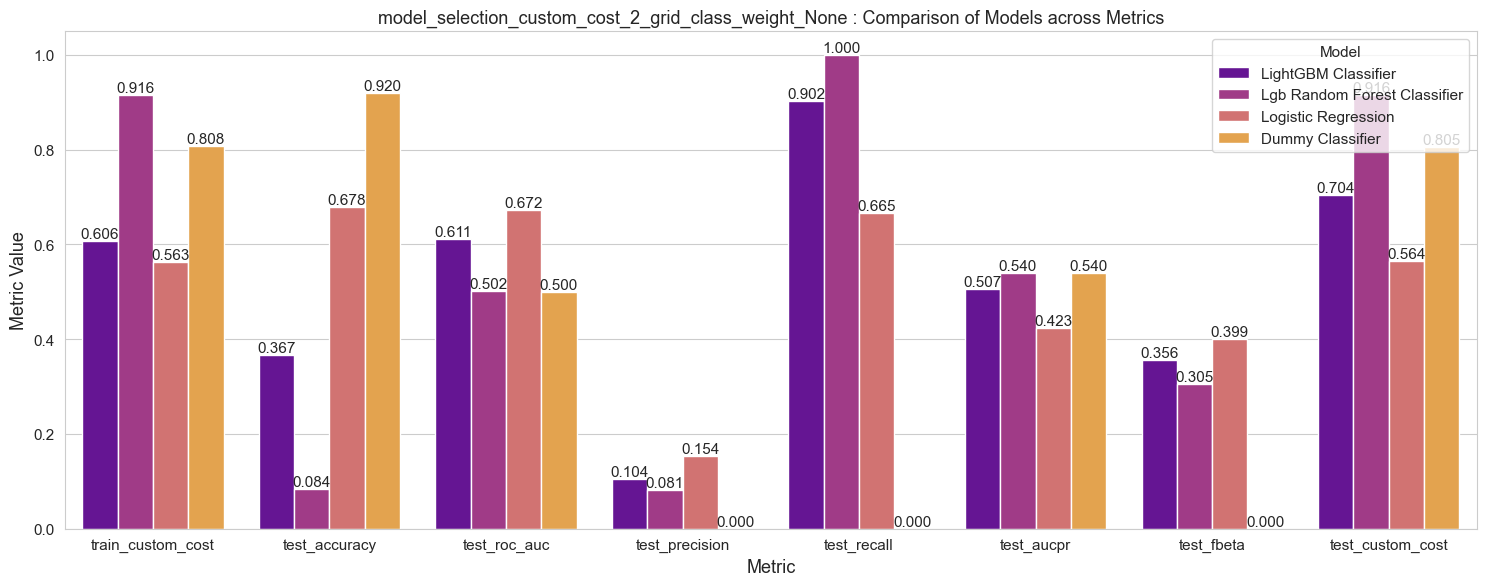

In [22]:
# List of scoring metrics to test
scoring_metrics = [
    {'metric': 'roc_auc', 'beta': 2},  
    {'metric': 'custom_cost', 'beta': 2} 
]

# Base parameters
run_params_base_3 = {
    'run_type': 'model_selection',
    'search_type': 'grid',
    'sampling_method':'class_weight',
    'sampling_strategy' : None,
    'fp_weight': 1,
    'fn_weight': 10,
    'register' : False,
    'optim_threshold' : False
}

# Loop over scoring metrics and update run parameters
for scoring in scoring_metrics:
    run_params = run_params_base_3.copy()  
    run_params['scoring_metric'] = scoring['metric']
    run_params['beta'] = scoring['beta']  
    
    # Print or use run_params for model training
    print("Running with parameters:", run_params)
    run_experiment(models, X_train, y_train, X_test, y_test, run_params)
    
    # Plot results
    parent_run_name = f"{run_params['run_type']}_{run_params['scoring_metric']}_{run_params['beta']}_{run_params['search_type']}_{run_params['sampling_method']}_{run_params['sampling_strategy']}"

    plot_model_comparisons(experiment_name, parent_run_name)

## Model comparison

In [ ]:
# Get Best model
best_model_df = compare_runs_across_specified_parent_runs(experiment_name, keyword="model_selection")

parent_run_name = best_model_df['parent_run'][0]
model_name = best_model_df['model'][0]

# Get best_params for best_model
best_params = get_logged_model_params(experiment_name, parent_run_name, model_name)

# Print classification params
classification_params = [
    {'classification': param['classification'].get_params()} for param in best_params if 'classification' in param
]

print('Best parameters : \n',json.dumps(classification_params, indent=4))

Best model based on composite ranking across test_custom_cost, test_roc_auc, and test_accuracy:


model_parent  \
0  model_selection_custom_cost_2_grid_none_None_lightgbm_classifier   

   test_custom_cost  test_roc_auc  test_accuracy  
0          0.773458      0.519638       0.919874

Best parameters : 
 [
    {
        "classification": {
            "boosting_type": "gbdt",
            "class_weight": null,
            "colsample_bytree": 1.0,
            "importance_type": "split",
            "learning_rate": 0.1,
            "max_depth": -1,
            "min_child_samples": 20,
            "min_child_weight": 0.001,
            "min_split_gain": 0.0,
            "n_estimators": 500,
            "n_jobs": null,
            "num_leaves": 31,
            "objective": "binary",
            "random_state": 42,
            "reg_alpha": 0.0,
            "reg_lambda": 0.0,
            "subsample": 1.0,
            "subsample_for_bin": 200000,
            "subsample_freq": 0
        }
    }
]


# Model optimisation

In [26]:
models = {
    # LightGBM Classifier
    'LightGBM Classifier': (LGBMClassifier(class_weight='balanced',
                                           is_unbalance=True,
                                           objective='binary', 
                                           random_state=seed), {
        'classification__n_estimators': [50, 100, 150],
        'classification__learning_rate': [0.001, 0.01, 0.1],
        'classification__max_depth': [-1, 3, 7],
        'classification__num_leaves': [31, 63, 127],
    })
}

Running with parameters: {'run_type': 'model_optimisation', 'search_type': 'grid', 'scoring_metric': 'custom_cost', 'sampling_method': 'class_weight', 'sampling_strategy': None, 'beta': 2, 'fp_weight': 1, 'fn_weight': 10, 'register': True, 'optim_threshold': True}
Parent Run: model_optimisation_custom_cost_2_grid_class_weight_None
Running LightGBM Classifier...
Optimal threshold : 0.89 with custom_cost value: 0.17


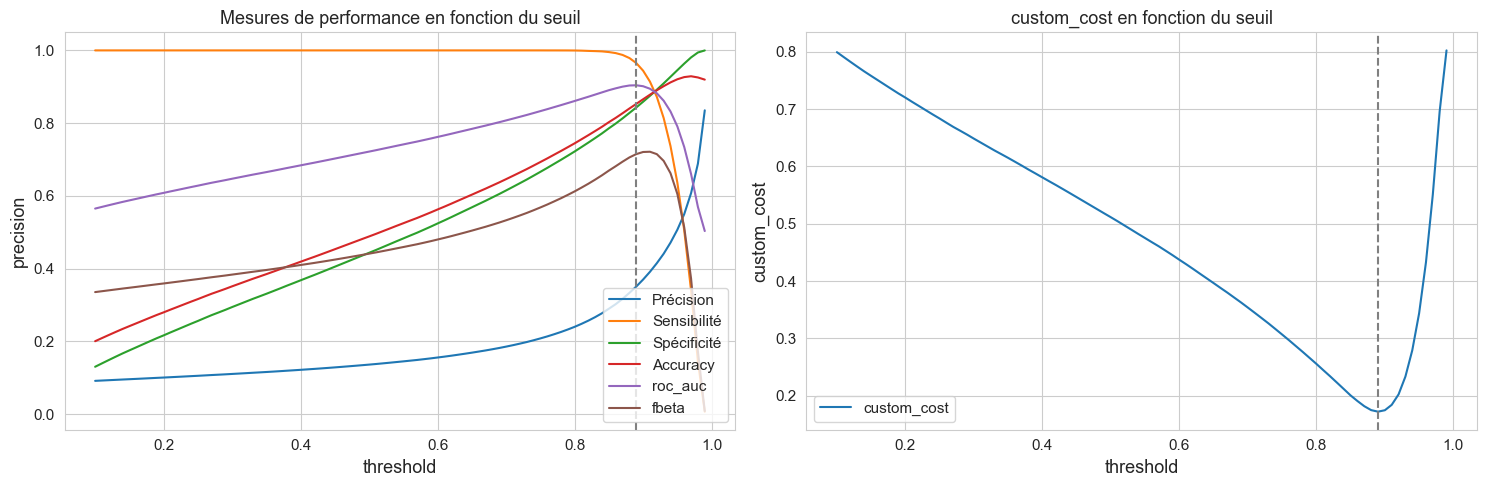

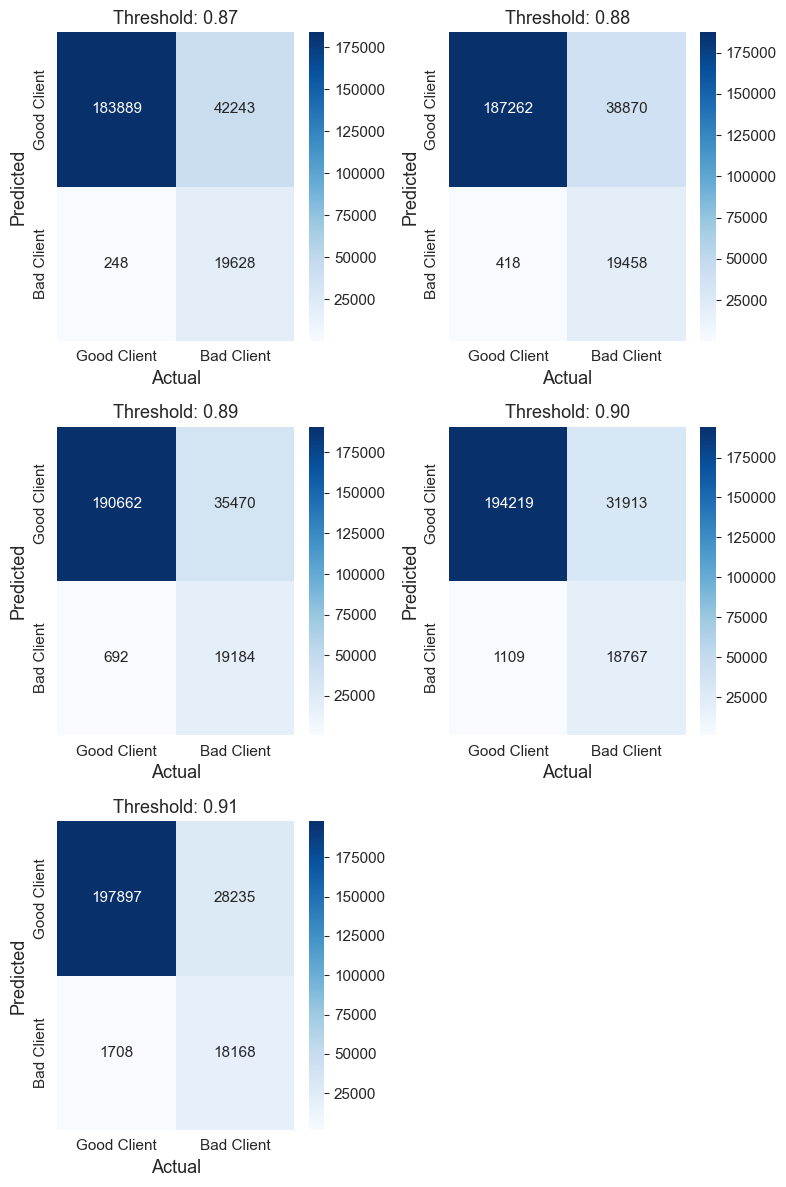

Best custom_cost for threshold = 0.89


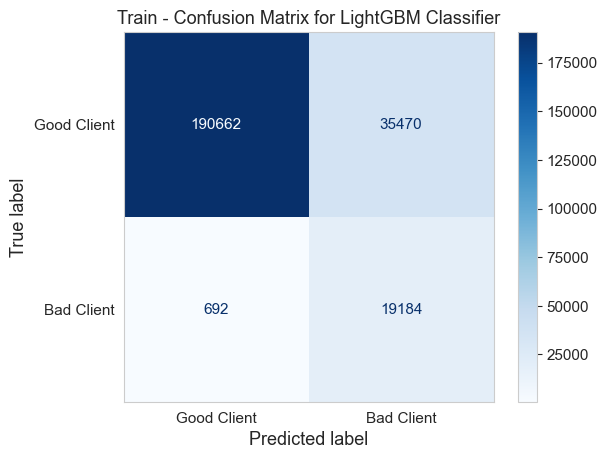

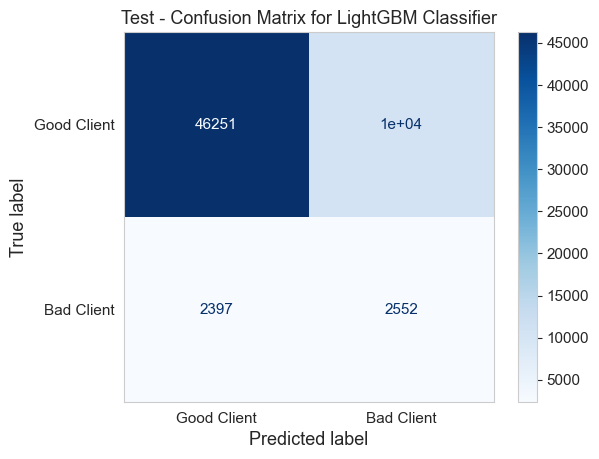

Registered model 'model_optimisation_custom_cost_2_grid_class_weight_None_lightgbm_classifier' already exists. Creating a new version of this model...
2024/11/08 14:44:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_optimisation_custom_cost_2_grid_class_weight_None_lightgbm_classifier, version 2
Created version '2' of model 'model_optimisation_custom_cost_2_grid_class_weight_None_lightgbm_classifier'.
2024/11/08 14:44:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM Classifier at: http://localhost:5000/#/experiments/9/runs/845ba8cef938448a80051470384d1cc6.
2024/11/08 14:44:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.
2024/11/08 14:44:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_optimisation_custom_cost_2_grid_class_weight_None at: http://localhost:5000/#/experiments/9/runs/187766c5eb1f411ebf610

Model registered as model_optimisation_custom_cost_2_grid_class_weight_None_lightgbm_classifier.
Best LightGBM Classifier model saved in MLflow with custom_cost: -0.622
All models have been tuned and logged in MLflow.


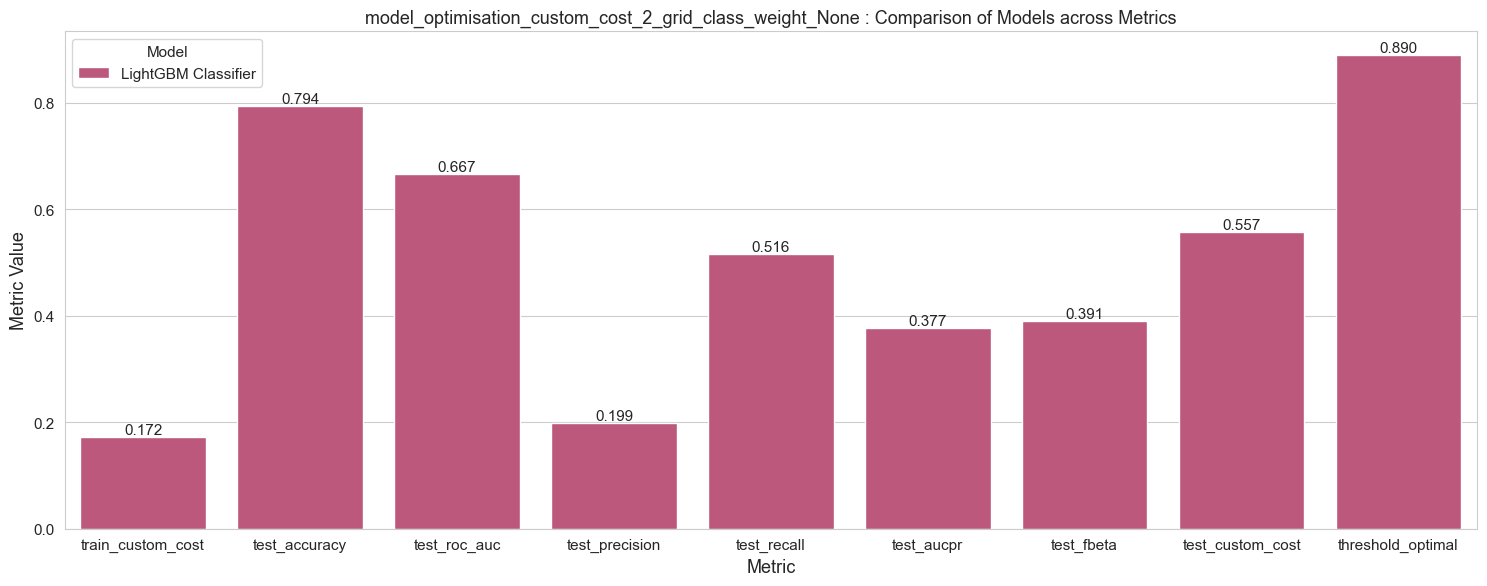

In [27]:
# Parameters
run_params = {
    'run_type': 'model_optimisation',
    'search_type': 'grid',
    'scoring_metric':'custom_cost',
    'sampling_method':'class_weight',
    'sampling_strategy' : None,
    'beta':2,
    'fp_weight': 1,
    'fn_weight': 10,
    'register' : True,
    'optim_threshold' : True
}
 

# Print or use run_params for model training
print("Running with parameters:", run_params)
run_experiment(models, X_train, y_train, X_test, y_test, run_params)

# Plot results
parent_run_name = f"{run_params['run_type']}_{run_params['scoring_metric']}_{run_params['beta']}_{run_params['search_type']}_{run_params['sampling_method']}_{run_params['sampling_strategy']}"

plot_model_comparisons(experiment_name, parent_run_name)

# Feature importance

In [28]:
def load_model_scaler(model_name):
    """!
    @brief: Load the latest version of a model from the MLflow model registry.
    @param model_name: str, the name of the model registered in MLflow.
    @return: Loaded model instance.
    """
    client = MlflowClient()
    
    # Define model URI using the alias 'champion' and load model
    model_uri = f"models:/{model_name}@champion"
    pipeline = mlflow.sklearn.load_model(model_uri)

    # Extract the model and scaler from the pipeline
    model = pipeline.named_steps['classification']
    scaler = pipeline.named_steps['scaling']
    
    return model, scaler

In [30]:
model_name = 'model_optimisation_custom_cost_2_grid_class_weight_None_lightgbm_classifier'

In [31]:
final_model, scaler = load_model_scaler(model_name)

In [32]:
# Fit imputer 
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

# Impute missing values
X_test_imputed = imputer.transform(X_test)

# Scale data
X_test_scaled = scaler.transform(X_test_imputed)

## Feature importance globale

In [33]:
# Feature importance globale
global_feature_importance = final_model.feature_importances_

In [34]:
feature_names = X_train.columns

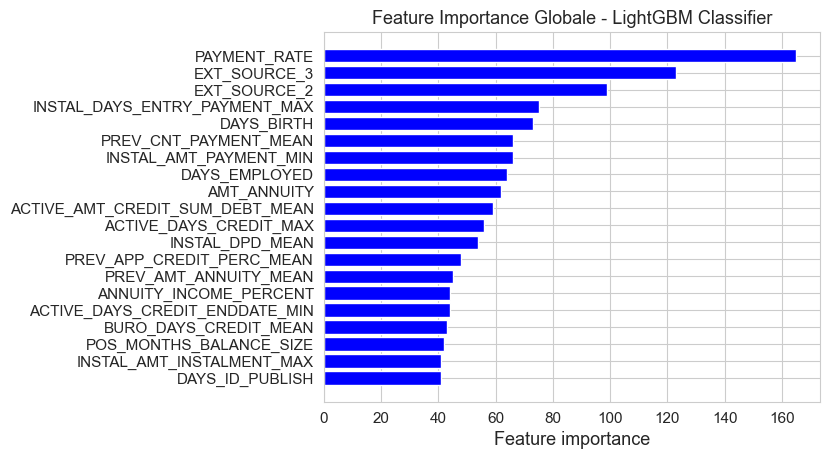

In [35]:
# Affichage du top 20 des features par importance
top_x = 20
indices = np.argsort(global_feature_importance)
indices = indices[-top_x:]

plt.barh(range(len(indices)), global_feature_importance[indices], color='b', align='center') 
plt.title('Feature Importance Globale - LightGBM Classifier')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices]) 
plt.xlabel('Feature importance')
plt.show()

In [36]:
# Récupération des valeurs de Shapley
explainer = shap.TreeExplainer(final_model)

In [37]:
shap_values = explainer.shap_values(X_test_scaled)

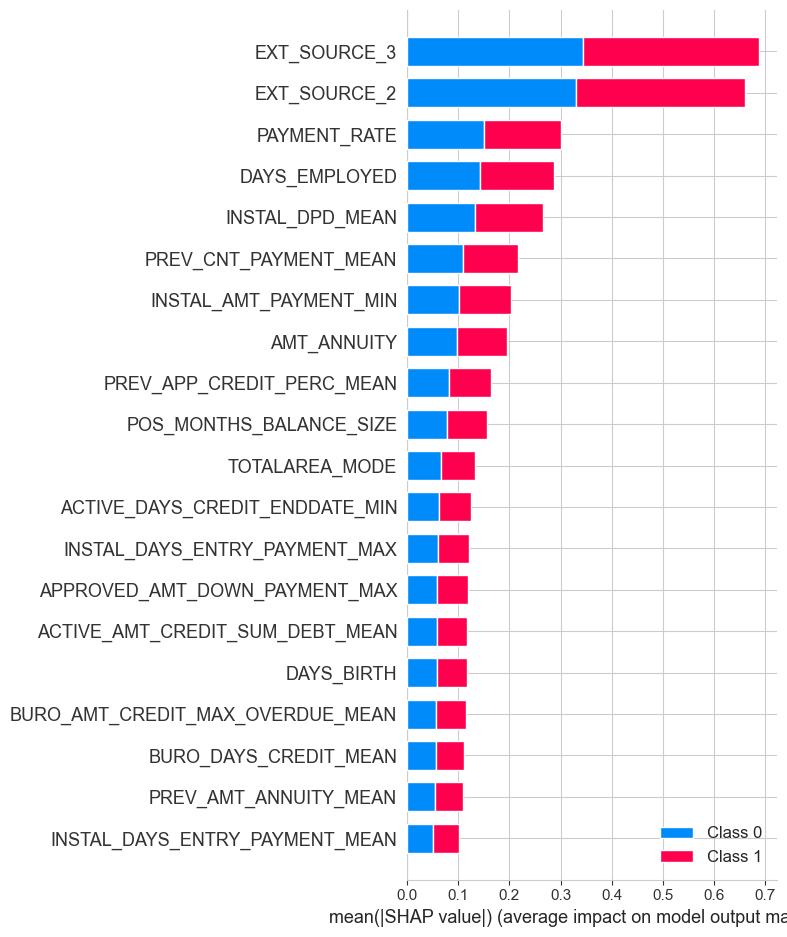

In [38]:
shap.summary_plot(shap_values,
                  features = X_test_scaled,
                  feature_names=feature_names)

## Feature importance locale

### Good client

In [39]:
# Index of good client
index_good_client = y_test[y_test == 0].index[0]
display(X_test.loc[index_good_client])
loc = X_test.index.get_loc(index_good_client)

# force plot
shap.force_plot(explainer.expected_value[0], 
                explainer.shap_values(X_test_scaled[loc].reshape(1, -1))[0], 
                X_test_scaled[loc].reshape(1, -1), 
                feature_names=feature_names,
                out_names="")

EXT_SOURCE_2                                    0.604894
PAYMENT_RATE                                    0.113095
EXT_SOURCE_3                                    0.000527
DAYS_BIRTH                                  13297.000000
DAYS_EMPLOYED                                -762.000000
DAYS_REGISTRATION                            -637.000000
DAYS_ID_PUBLISH                             -4307.000000
ANNUITY_INCOME_PERCENT                          0.254304
INSTAL_DBD_MEAN                                 9.000000
DAYS_LAST_PHONE_CHANGE                         -2.000000
AMT_ANNUITY                                 52641.000000
ACTIVE_DAYS_CREDIT_UPDATE_MEAN               -218.000000
REGION_POPULATION_RELATIVE                      0.009630
INSTAL_DAYS_ENTRY_PAYMENT_MAX               -1627.000000
CLOSED_DAYS_CREDIT_MAX                       -587.000000
ACTIVE_DAYS_CREDIT_ENDDATE_MIN              -2710.000000
INSTAL_AMT_PAYMENT_MIN                          0.045000
PREV_APP_CREDIT_PERC_VAR       

In [40]:
# Index of good client
index_good_client = y_test[y_test == 0].index[1]
display(X_test.loc[index_good_client])
loc = X_test.index.get_loc(index_good_client)

# force plot
shap.force_plot(explainer.expected_value[0], 
                explainer.shap_values(X_test_scaled[loc].reshape(1, -1))[0], 
                X_test_scaled[loc].reshape(1, -1), 
                feature_names=feature_names,
                out_names="")

EXT_SOURCE_2                               4.253505e-01
PAYMENT_RATE                               3.818836e-02
EXT_SOURCE_3                               7.121552e-01
DAYS_BIRTH                                 1.477800e+04
DAYS_EMPLOYED                             -1.141000e+03
DAYS_REGISTRATION                         -1.610000e+03
DAYS_ID_PUBLISH                           -4.546000e+03
ANNUITY_INCOME_PERCENT                     1.977636e-01
INSTAL_DBD_MEAN                            9.485714e+00
DAYS_LAST_PHONE_CHANGE                    -1.071000e+03
AMT_ANNUITY                                4.894650e+04
ACTIVE_DAYS_CREDIT_UPDATE_MEAN            -5.200000e+01
REGION_POPULATION_RELATIVE                 6.852000e-03
INSTAL_DAYS_ENTRY_PAYMENT_MAX             -3.400000e+01
CLOSED_DAYS_CREDIT_MAX                    -2.950000e+02
ACTIVE_DAYS_CREDIT_ENDDATE_MIN             1.488000e+03
INSTAL_AMT_PAYMENT_MIN                     8.365500e+01
PREV_APP_CREDIT_PERC_VAR                   5.456

### Bad client

In [47]:
# Loc of bad client
index_bad_client = y_test[y_test == 1].index[0]
display(X_test.loc[index_bad_client])
loc_bad = X_test.index.get_loc(index_bad_client)

# force plot
shap.force_plot(explainer.expected_value[0], 
                explainer.shap_values(X_test_scaled[loc_bad].reshape(1, -1))[0], 
                X_test_scaled[loc_bad].reshape(1, -1), 
                feature_names=feature_names,
                out_names="")

EXT_SOURCE_2                               4.127344e-01
PAYMENT_RATE                               5.145065e-02
EXT_SOURCE_3                               6.397076e-01
DAYS_BIRTH                                 1.328000e+04
DAYS_EMPLOYED                             -2.800000e+02
DAYS_REGISTRATION                         -3.471000e+03
DAYS_ID_PUBLISH                           -4.880000e+03
ANNUITY_INCOME_PERCENT                     2.530000e-01
INSTAL_DBD_MEAN                            1.287500e+01
DAYS_LAST_PHONE_CHANGE                    -9.560000e+02
AMT_ANNUITY                                1.707750e+04
ACTIVE_DAYS_CREDIT_UPDATE_MEAN            -9.270000e+02
REGION_POPULATION_RELATIVE                 6.305000e-03
INSTAL_DAYS_ENTRY_PAYMENT_MAX             -6.140000e+02
CLOSED_DAYS_CREDIT_MAX                    -7.750000e+02
ACTIVE_DAYS_CREDIT_ENDDATE_MIN            -9.570000e+02
INSTAL_AMT_PAYMENT_MIN                     1.381252e+04
PREV_APP_CREDIT_PERC_VAR                   3.041

In [48]:
# Loc of bad client
index_bad_client = y_test[y_test == 1].index[1]
display(X_test.loc[index_bad_client])
loc_bad = X_test.index.get_loc(index_bad_client)

# force plot
shap.force_plot(explainer.expected_value[0], 
                explainer.shap_values(X_test_scaled[loc_bad].reshape(1, -1))[0], 
                X_test_scaled[loc_bad].reshape(1, -1), 
                feature_names=feature_names,
                out_names="")

EXT_SOURCE_2                                   0.453070
PAYMENT_RATE                                   0.049220
EXT_SOURCE_3                                   0.243186
DAYS_BIRTH                                  8438.000000
DAYS_EMPLOYED                               -809.000000
DAYS_REGISTRATION                          -3232.000000
DAYS_ID_PUBLISH                             -838.000000
ANNUITY_INCOME_PERCENT                         0.082033
INSTAL_DBD_MEAN                                9.068966
DAYS_LAST_PHONE_CHANGE                      -555.000000
AMT_ANNUITY                                11074.500000
ACTIVE_DAYS_CREDIT_UPDATE_MEAN              -400.333333
REGION_POPULATION_RELATIVE                     0.022800
INSTAL_DAYS_ENTRY_PAYMENT_MAX                -12.000000
CLOSED_DAYS_CREDIT_MAX                              NaN
ACTIVE_DAYS_CREDIT_ENDDATE_MIN              1108.000000
INSTAL_AMT_PAYMENT_MIN                       428.625000
PREV_APP_CREDIT_PERC_VAR                       0

# Save

In [46]:
# Initialize the MLflow client
client = MlflowClient()

# get latest version of model
latest_version_info = client.get_latest_versions(model_name)[-1]
latest_version = latest_version_info.version

# Transition the model version to Production
client.set_registered_model_alias(
    name=model_name,
    alias="champion",
    version=latest_version
)

print(f"Model '{model_name}' version {latest_version} has been assigned the alias 'champion' for production.")

Model 'model_optimisation_custom_cost_2_grid_class_weight_None_lightgbm_classifier' version 2 has been assigned the alias 'champion' for production.


In [61]:
parent_run_name = "model_optimisation_custom_cost_2_grid_class_weight_None"
run_name = 'LightGBM Classifier'

def get_threshold(experiment_name, parent_run_name, run_name):
    client = MlflowClient()

    # Get experience
    experiment = client.get_experiment_by_name(experiment_name)
    runs = client.search_runs(experiment_ids=[experiment.experiment_id])

    # Get parent_run_id
    parent_run_id = None
    for run in runs:
        if run.info.run_name == parent_run_name:
            parent_run_id = run.info.run_id
            break 


    # Get child run = `run_name`
    for run in runs:
        if (
            run.data.tags.get('mlflow.parentRunId') == parent_run_id 
            and run.info.run_name == run_name
        ):
            # Get optimal threshold
            threshold_value = run.data.metrics.get("threshold_optimal")
            
    return threshold_value


In [62]:
get_threshold(experiment_name, parent_run_name, run_name)

0.8899999999999996